---
# Notebook: Reporte de Estabilidade das Variáveis Selecionadas

Neste reporte, vamos visualizar e evidenciar gráficos de barras 100% empilhados que mostram a distribuição dos bins para cada variável, além de apresentar as estatísticas de estabilidade ao longo do tempo. Serão utilizados os seguintes indicadores:

- KS (variáveis numéricas):
Medida de estabilidade baseada no teste de Kolmogorov-Smirnov, que compara a distribuição dos valores da variável entre períodos consecutivos (safras). Valores mais altos indicam maior divergência entre as distribuições, sinalizando instabilidade na variável.

- PSI (variáveis categóricas):
Population Stability Index, que avalia as alterações na distribuição das categorias ao longo do tempo. Valores elevados de PSI sugerem mudanças significativas na distribuição, apontando para potenciais problemas de estabilidade.
---

# Imports

In [1]:

import pandas as pd
import numpy as np
import os
from pathlib import Path
import warnings
from matplotlib import pyplot as plt
from scipy.stats import ks_2samp
import yaml
from matplotlib.backends.backend_pdf import PdfPages

from src.utils.features_manager import get_features_by_property

# Configs Pandas
pd.options.display.max_columns = None
pd.options.display.max_colwidth = 200

# Configs matplotlib
plt.style.use('ggplot')

warnings.filterwarnings("ignore")

In [2]:
project_root = Path().resolve().parents[0]

In [3]:
df = pd.read_parquet(os.path.join(project_root, "data", "processed", "train.parquet"))

In [4]:
features_config_path = os.path.join(project_root, "src", "data", "config", "features.yaml")
features_selected = get_features_by_property(yaml_path=features_config_path, property_name="selected_by_boruta", property_value=True)
len(features_selected)

33

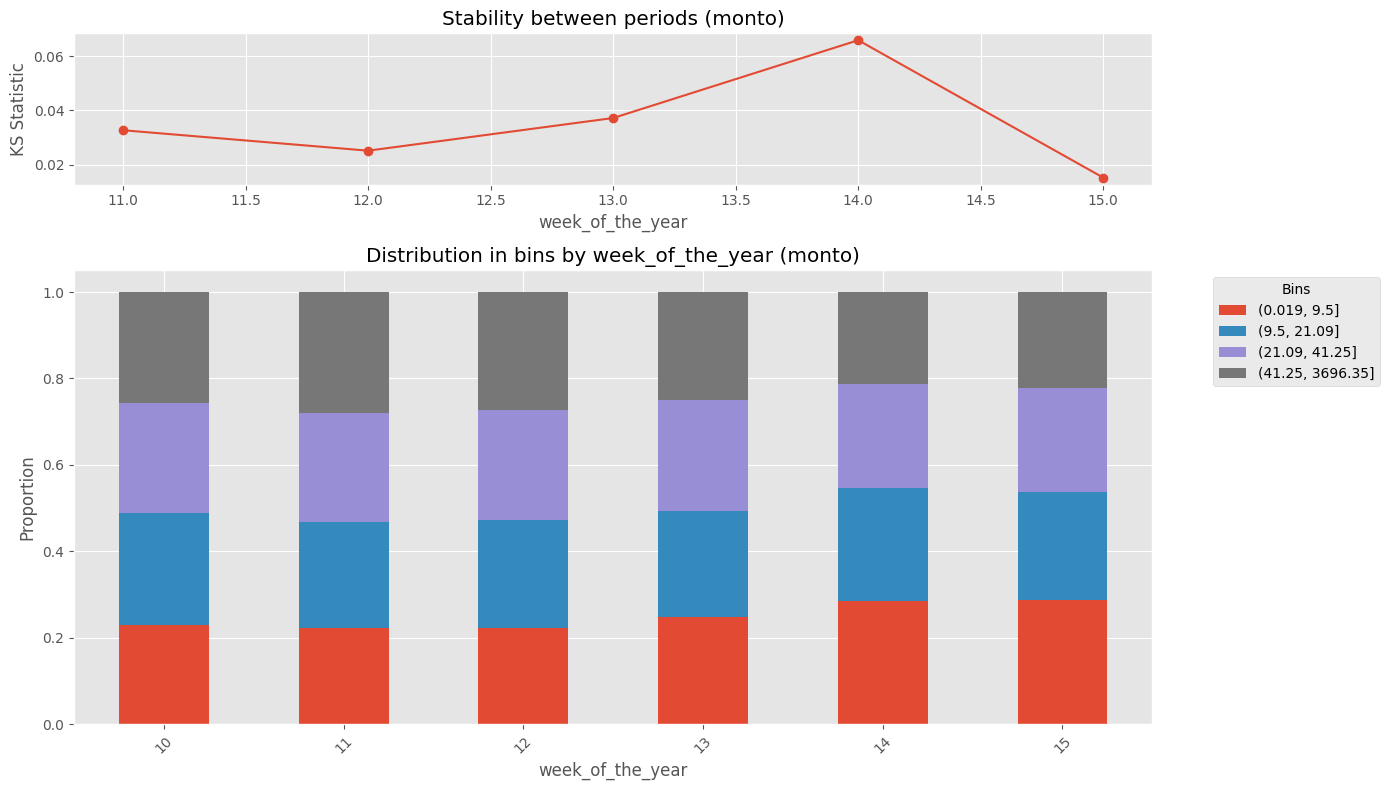

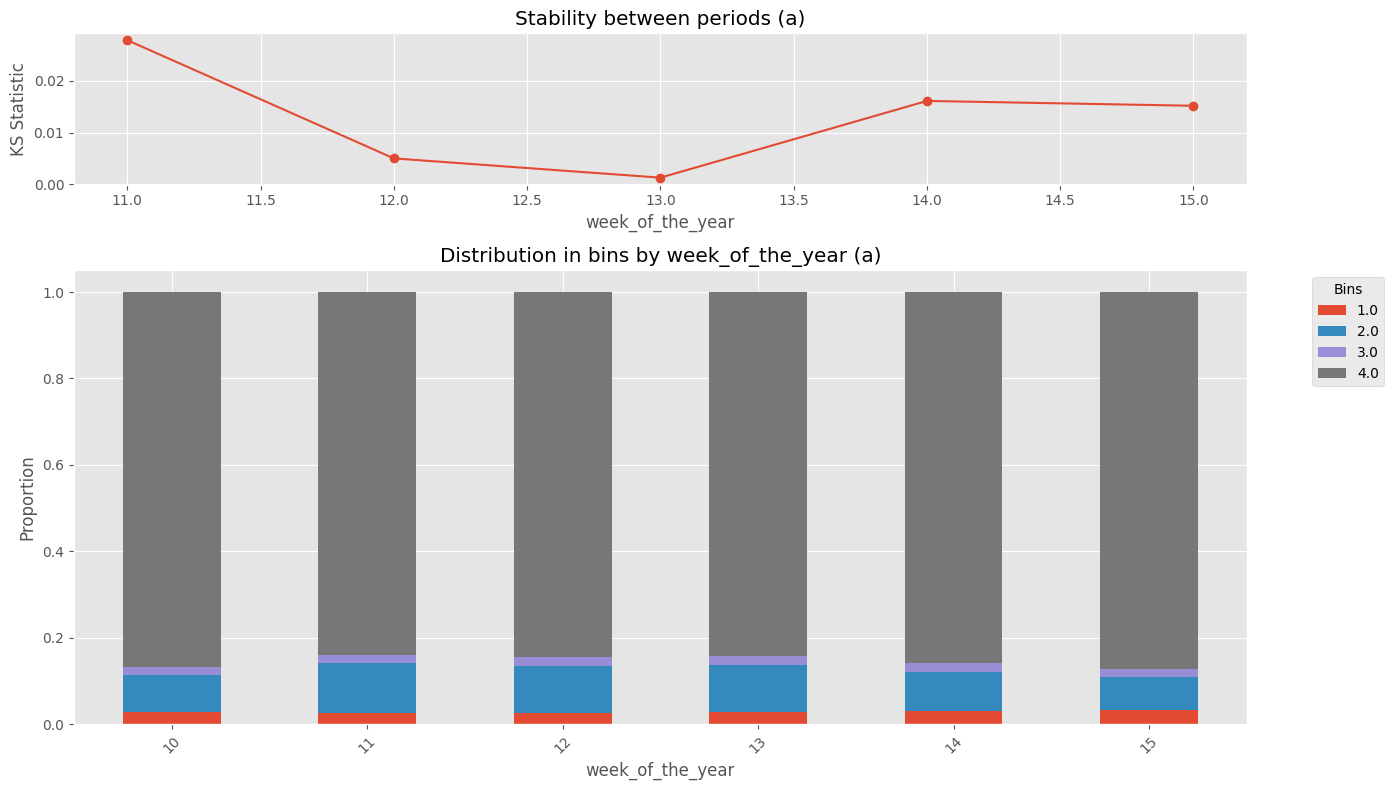

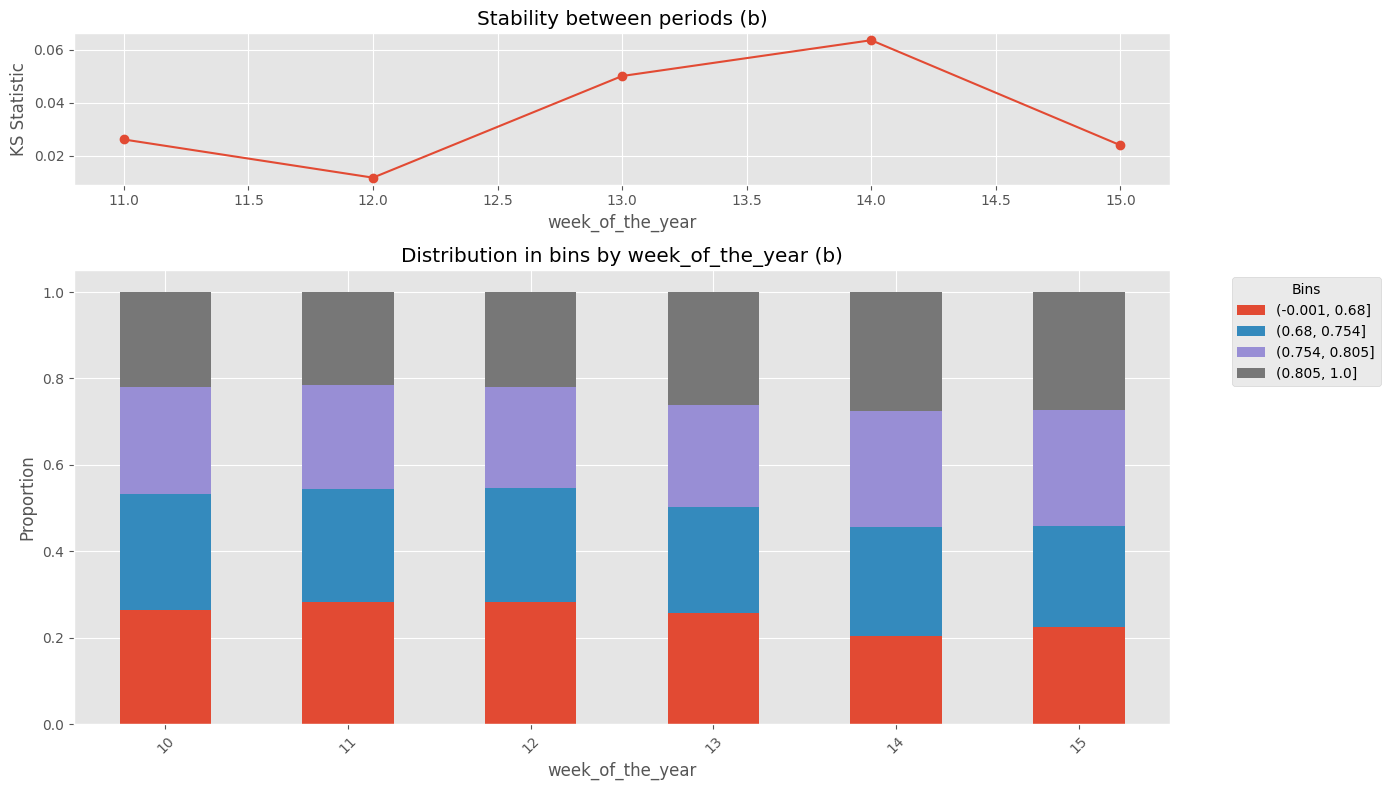

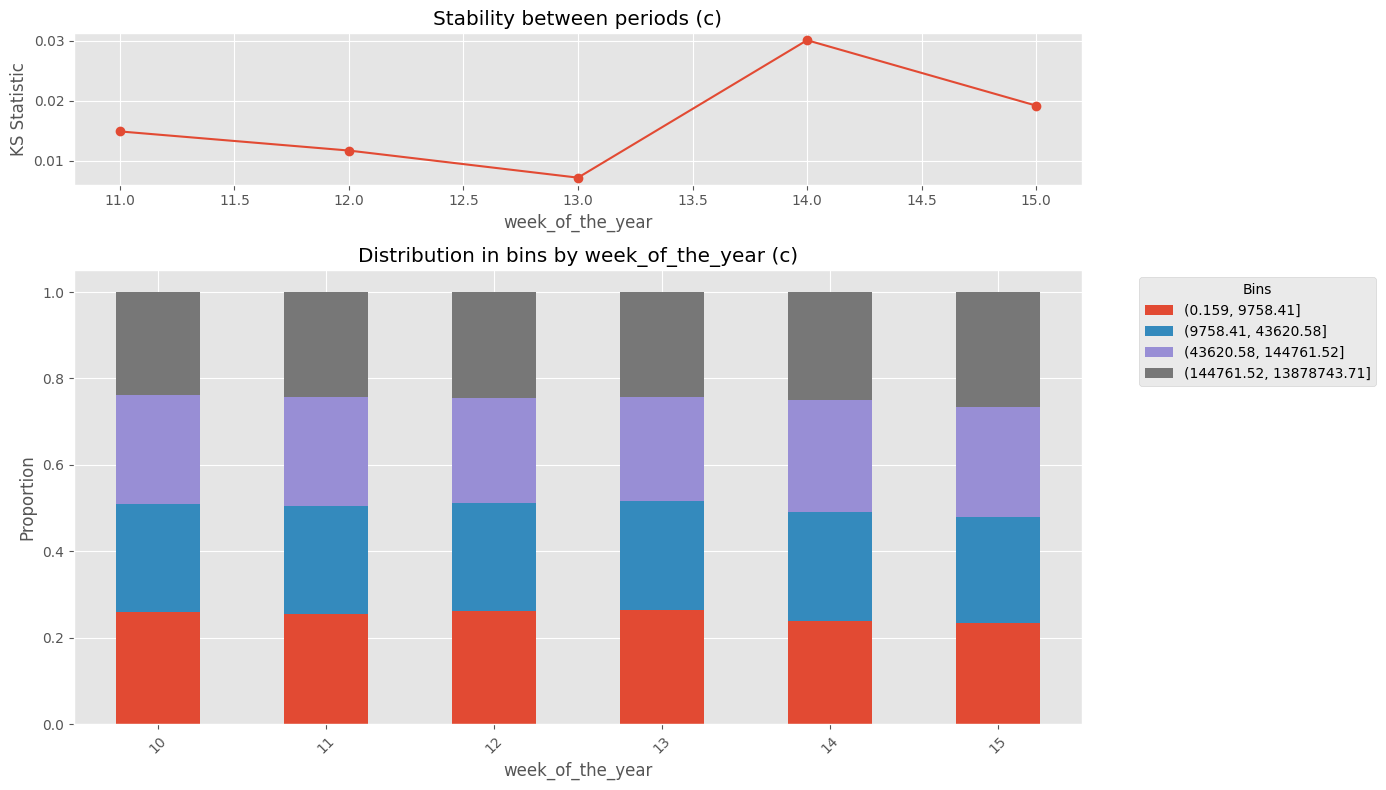

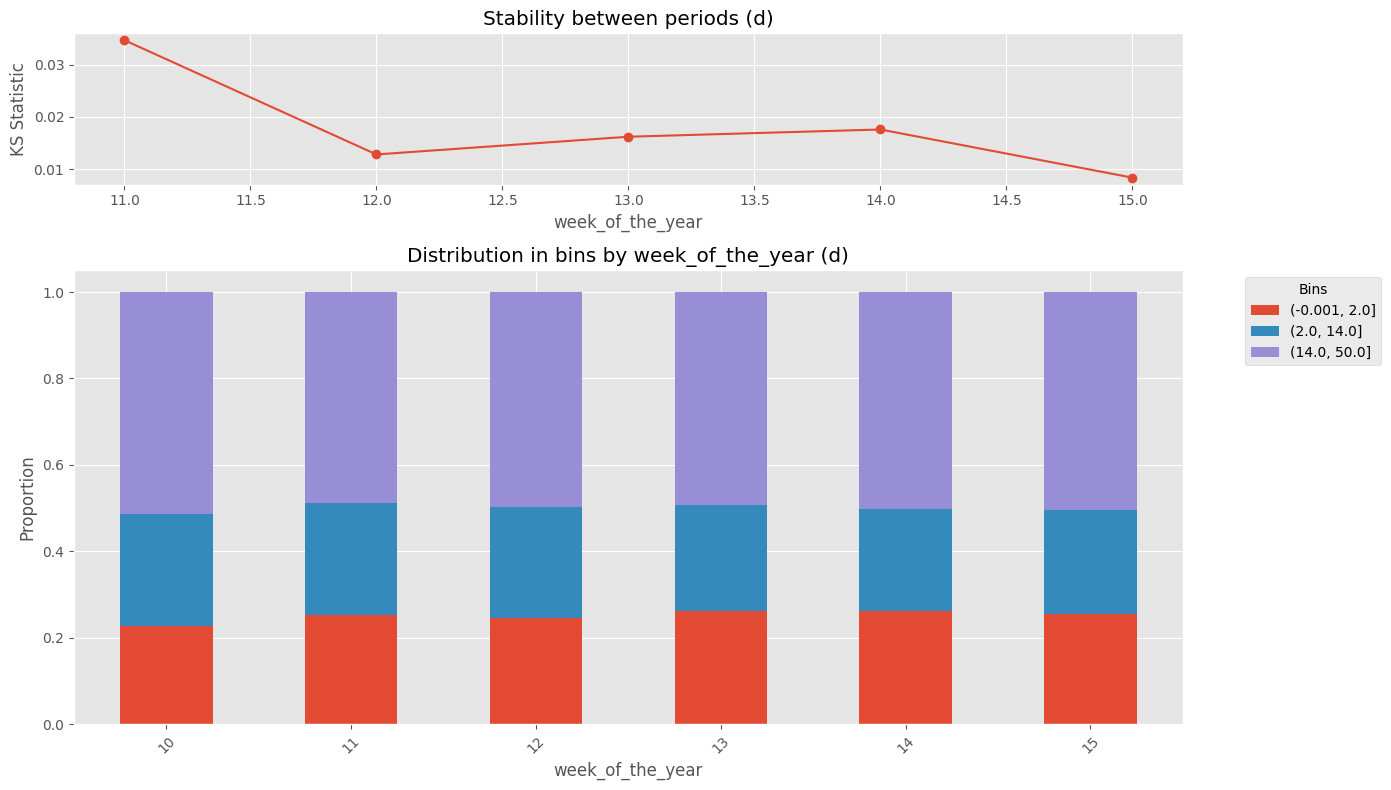

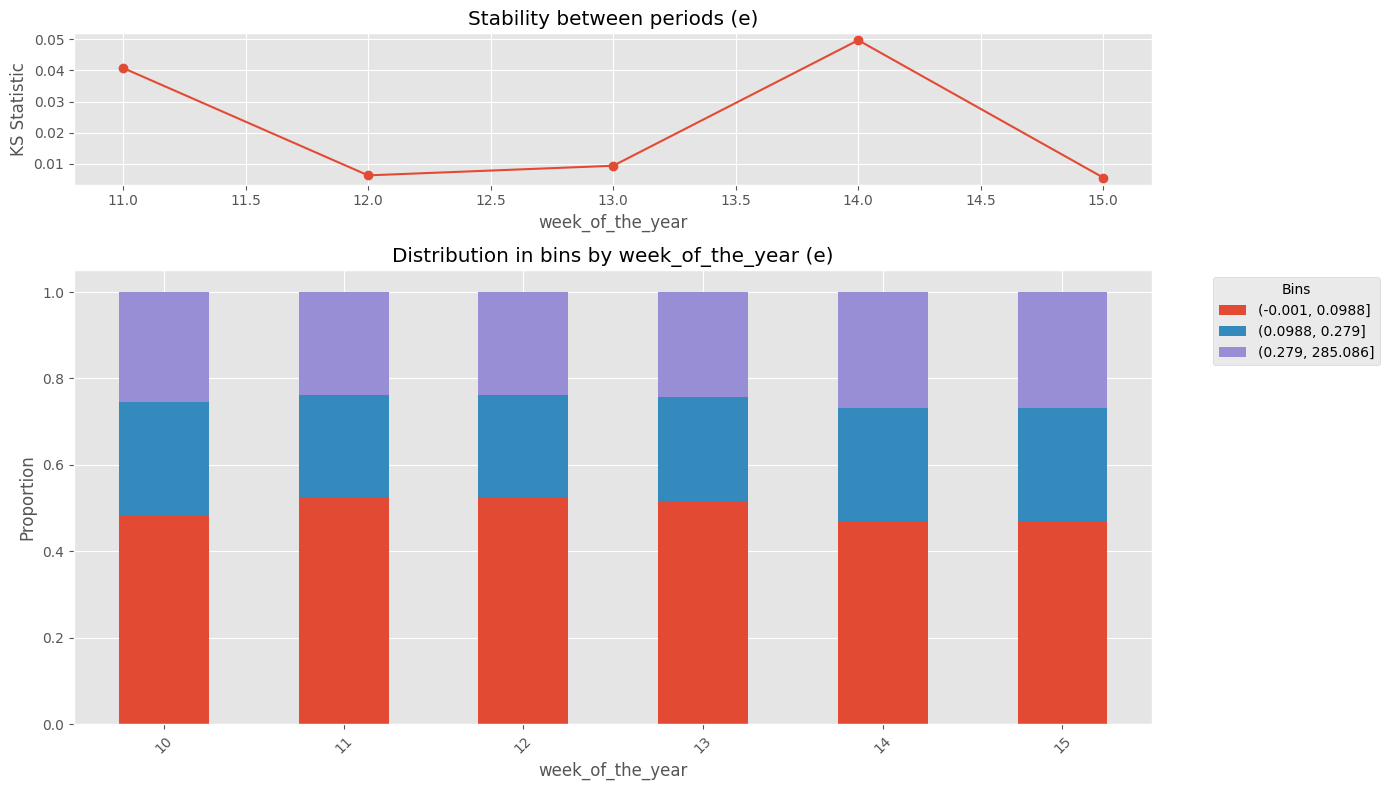

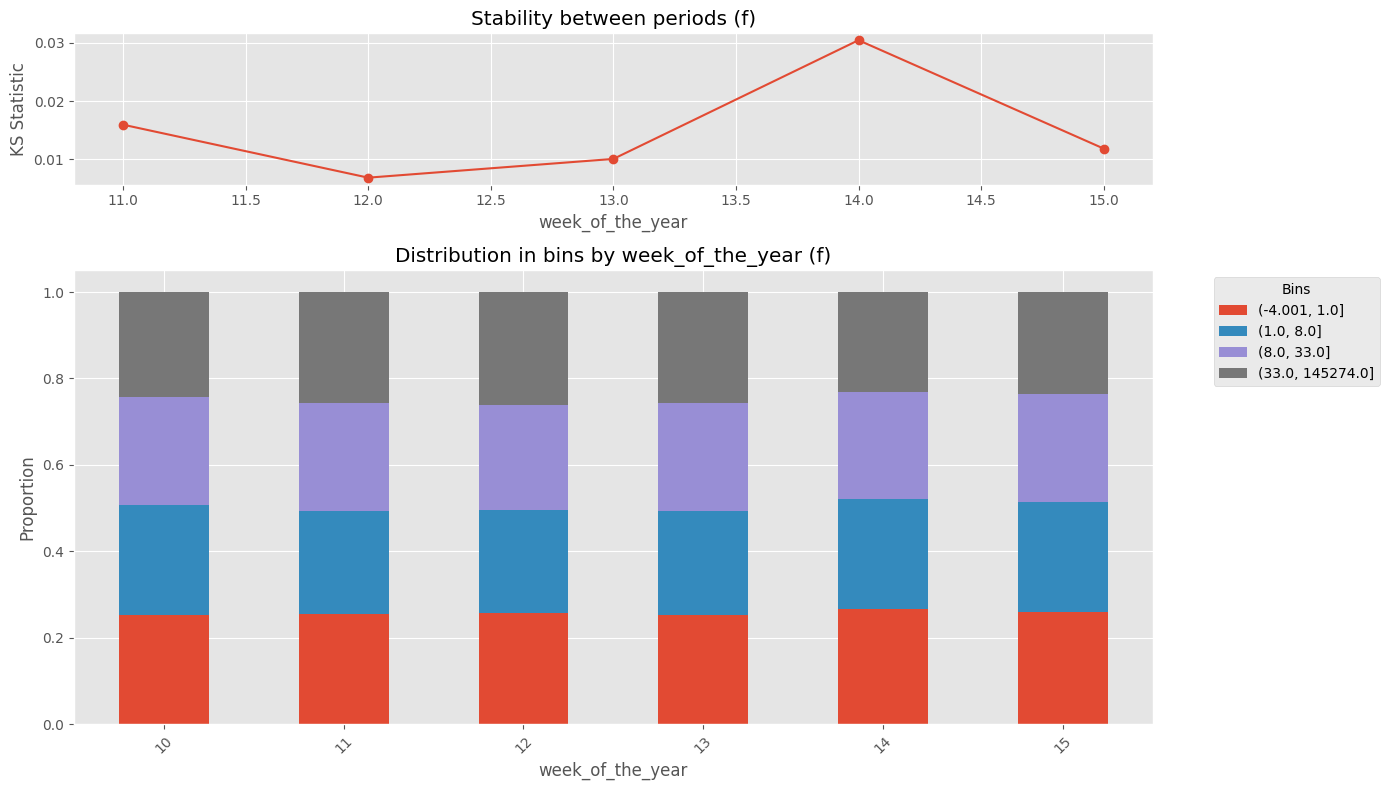

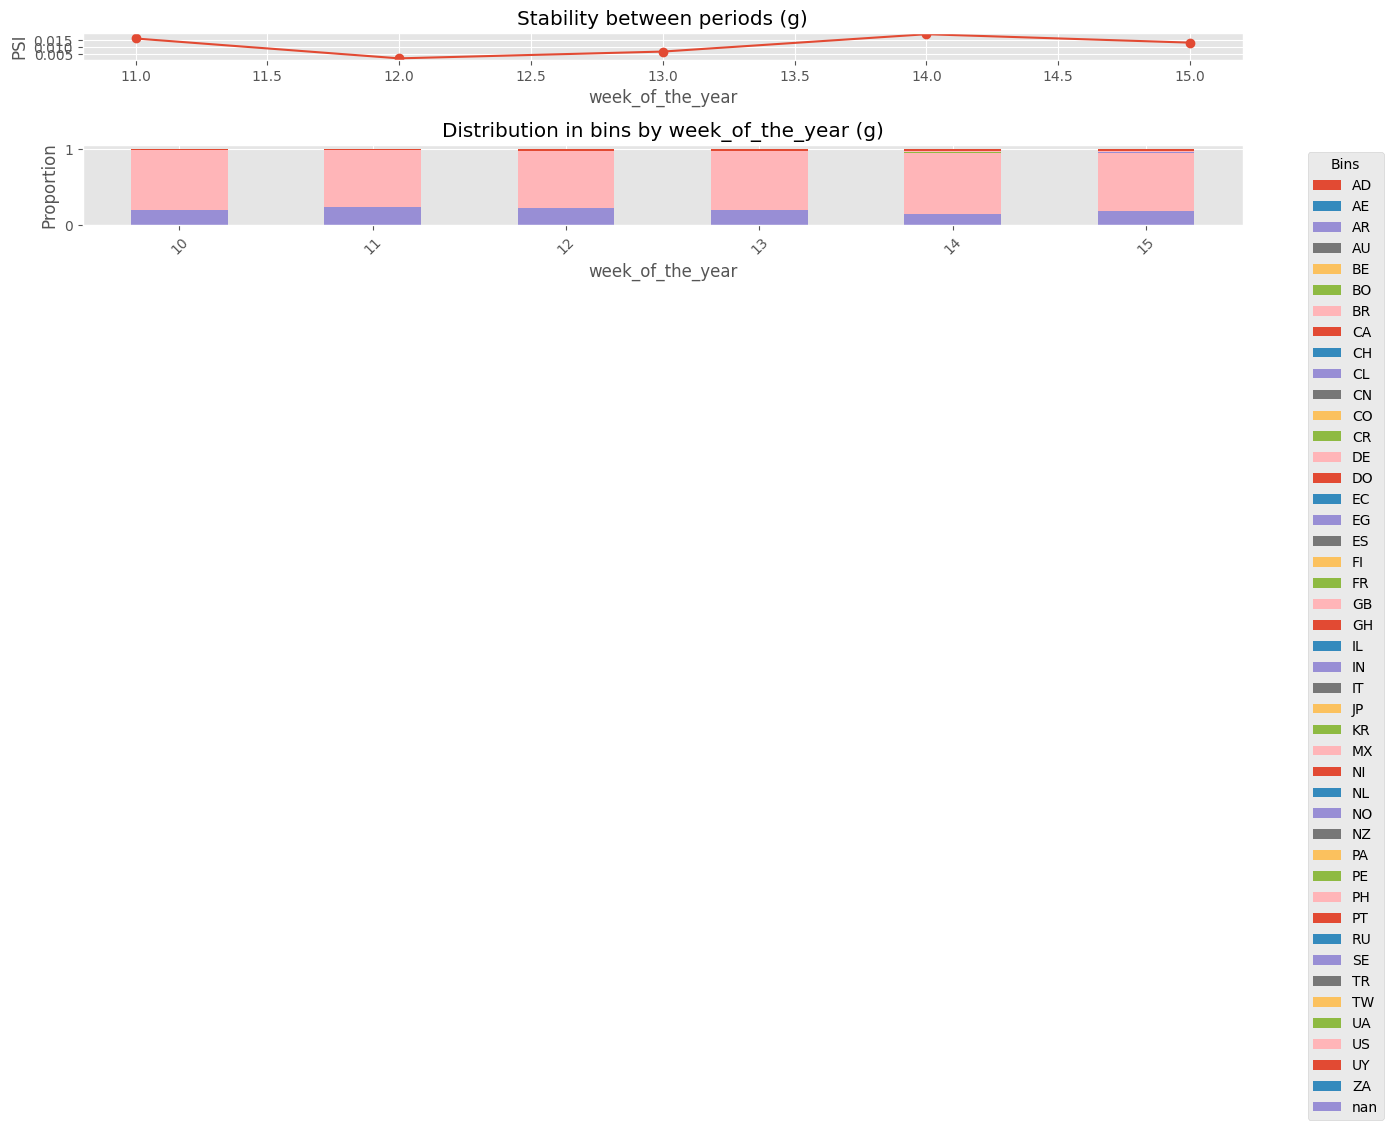

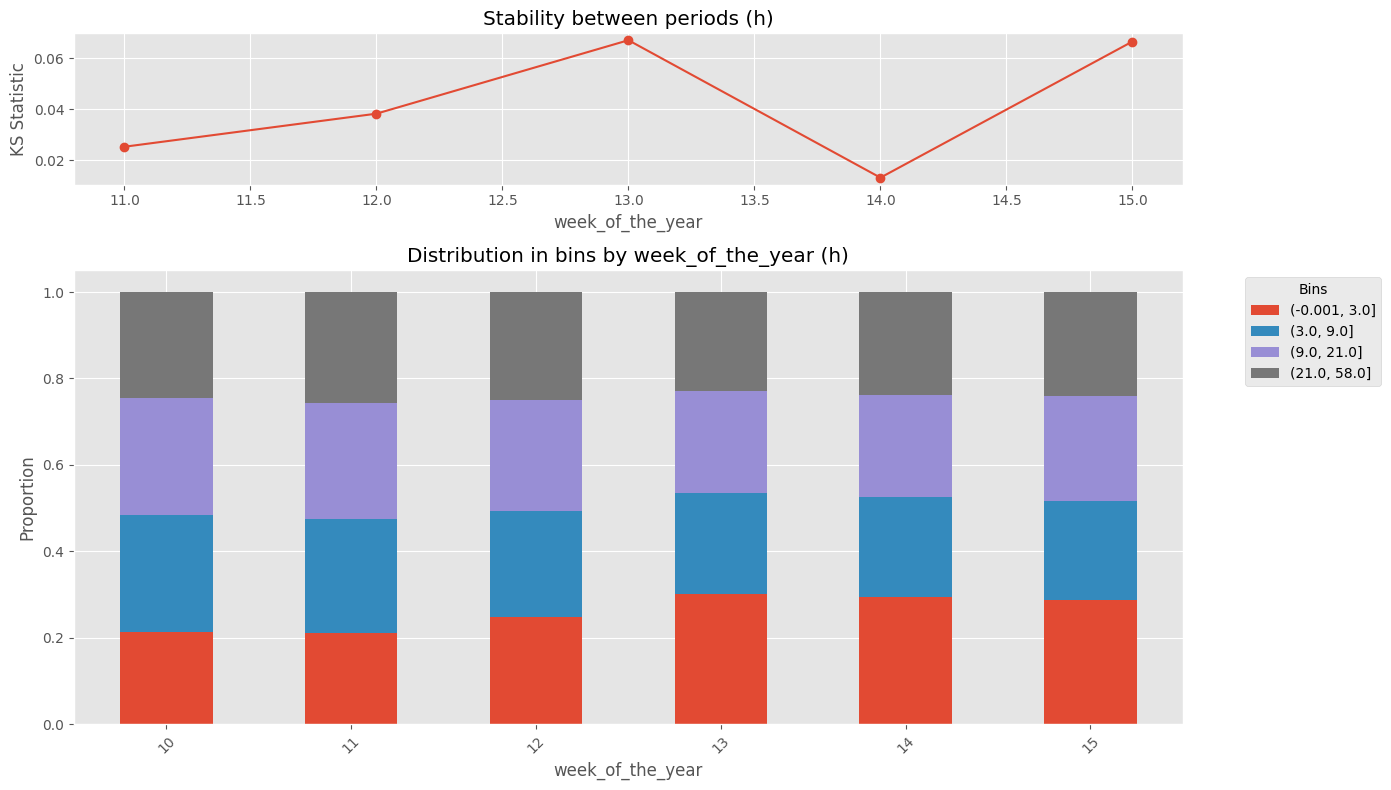

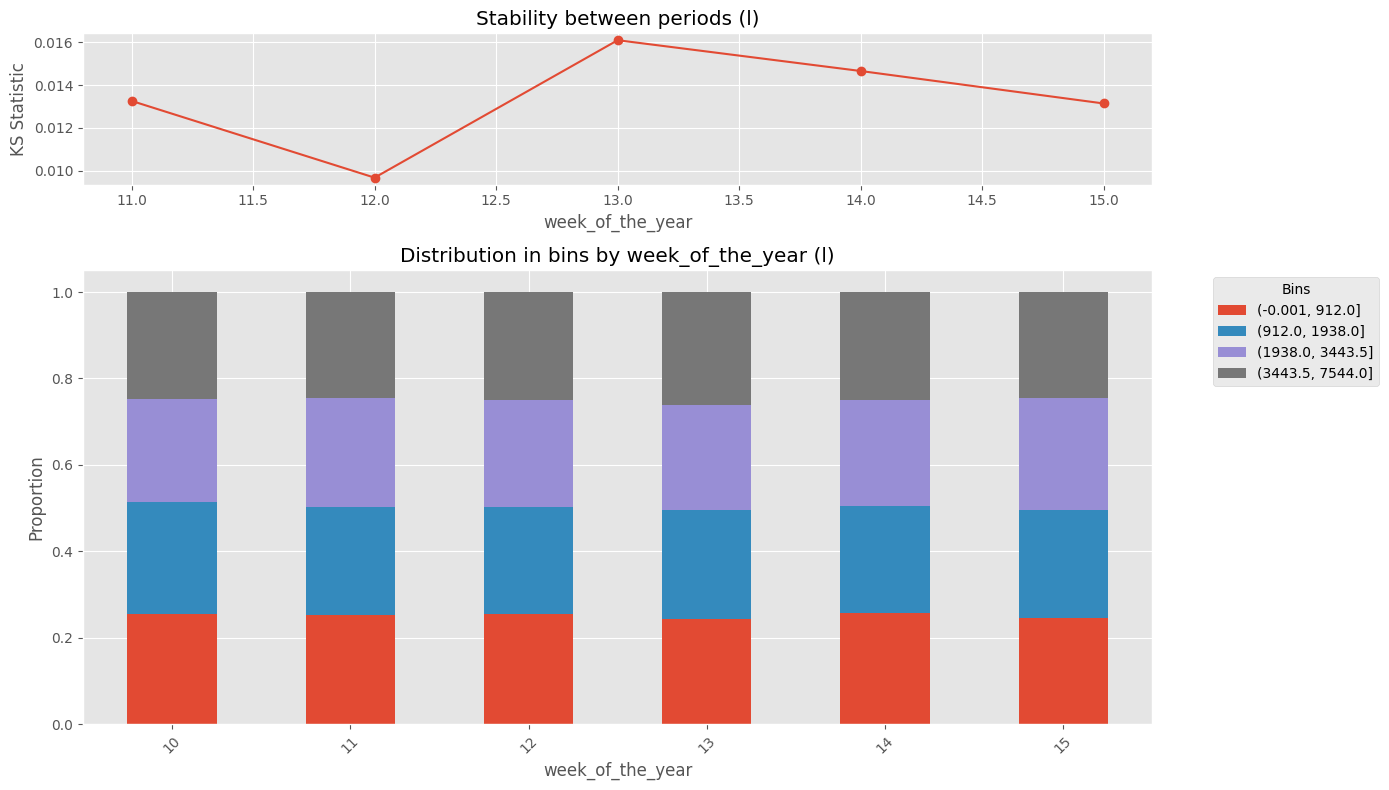

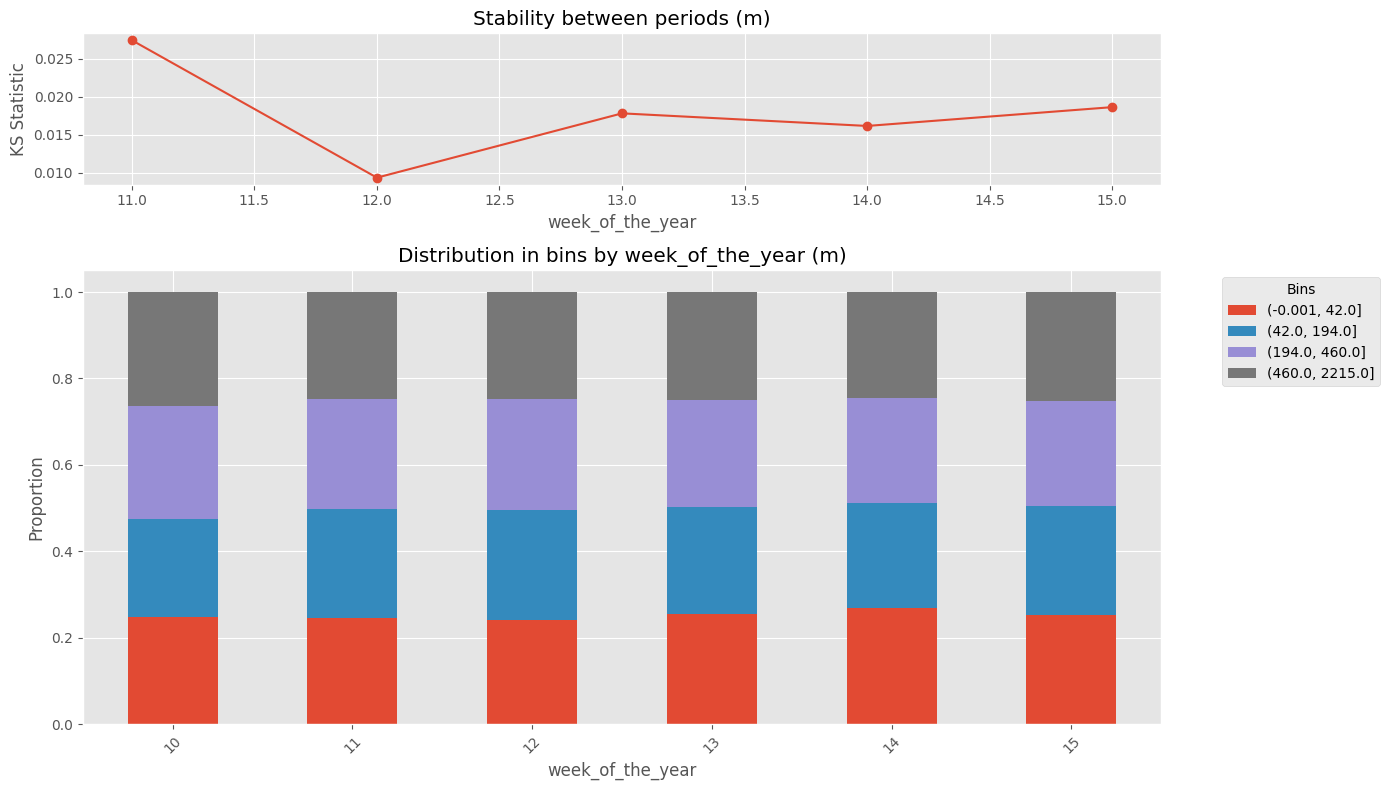

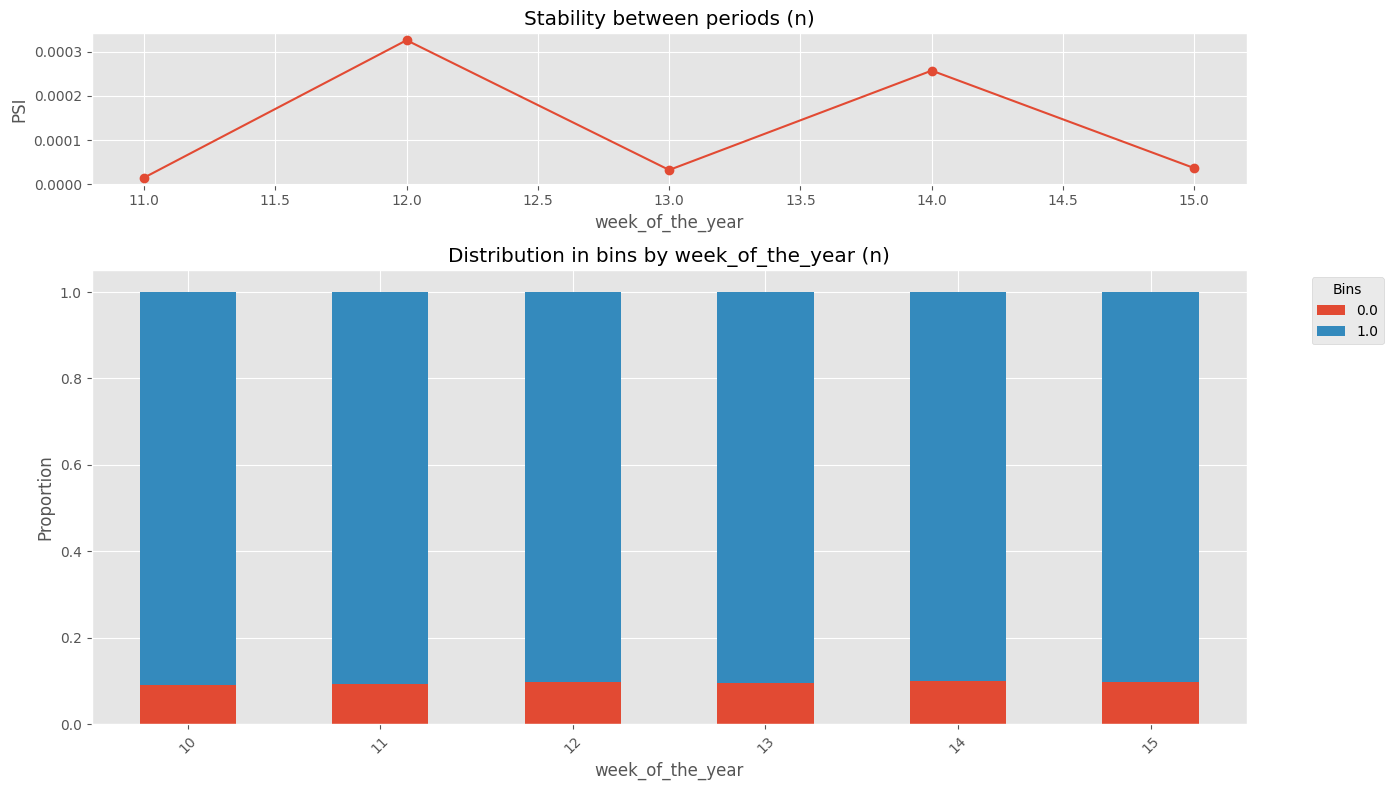

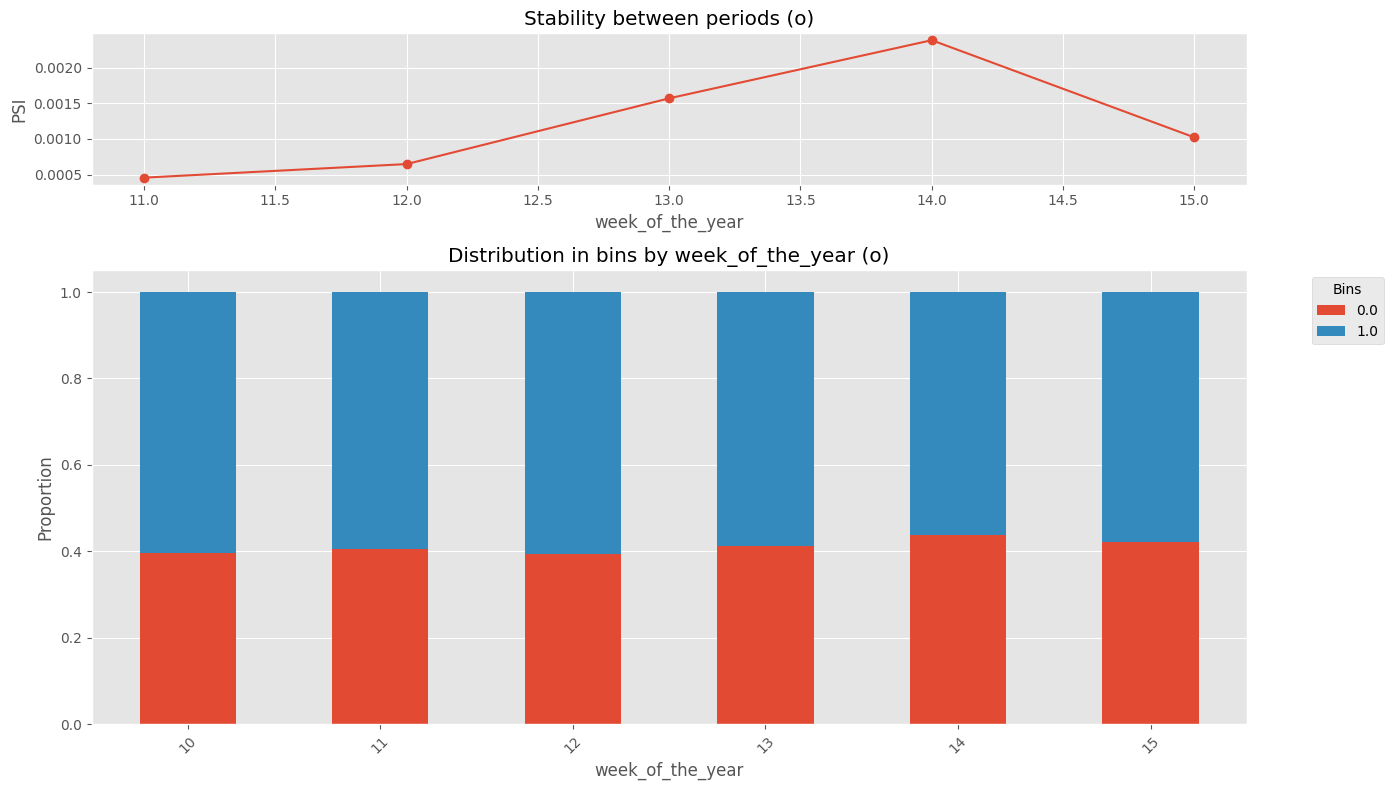

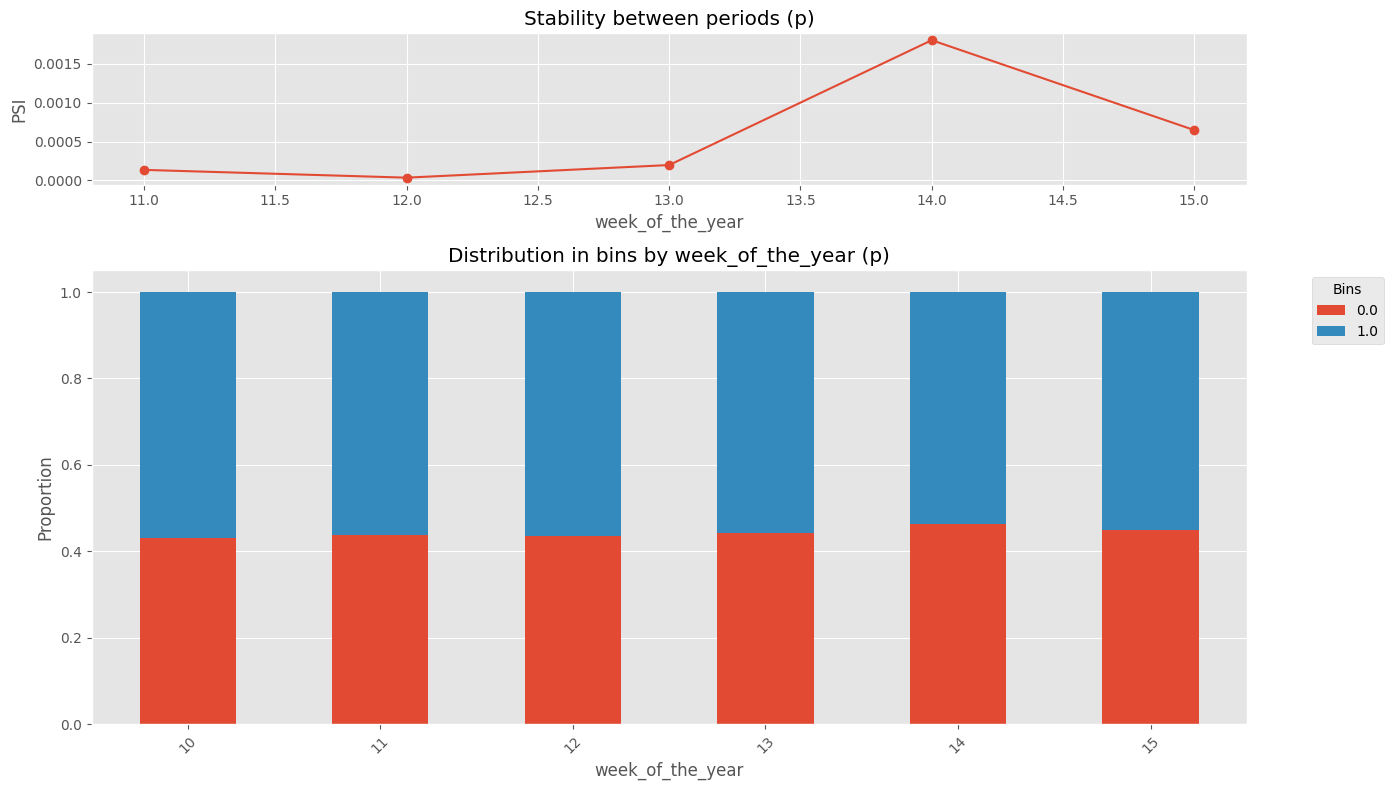

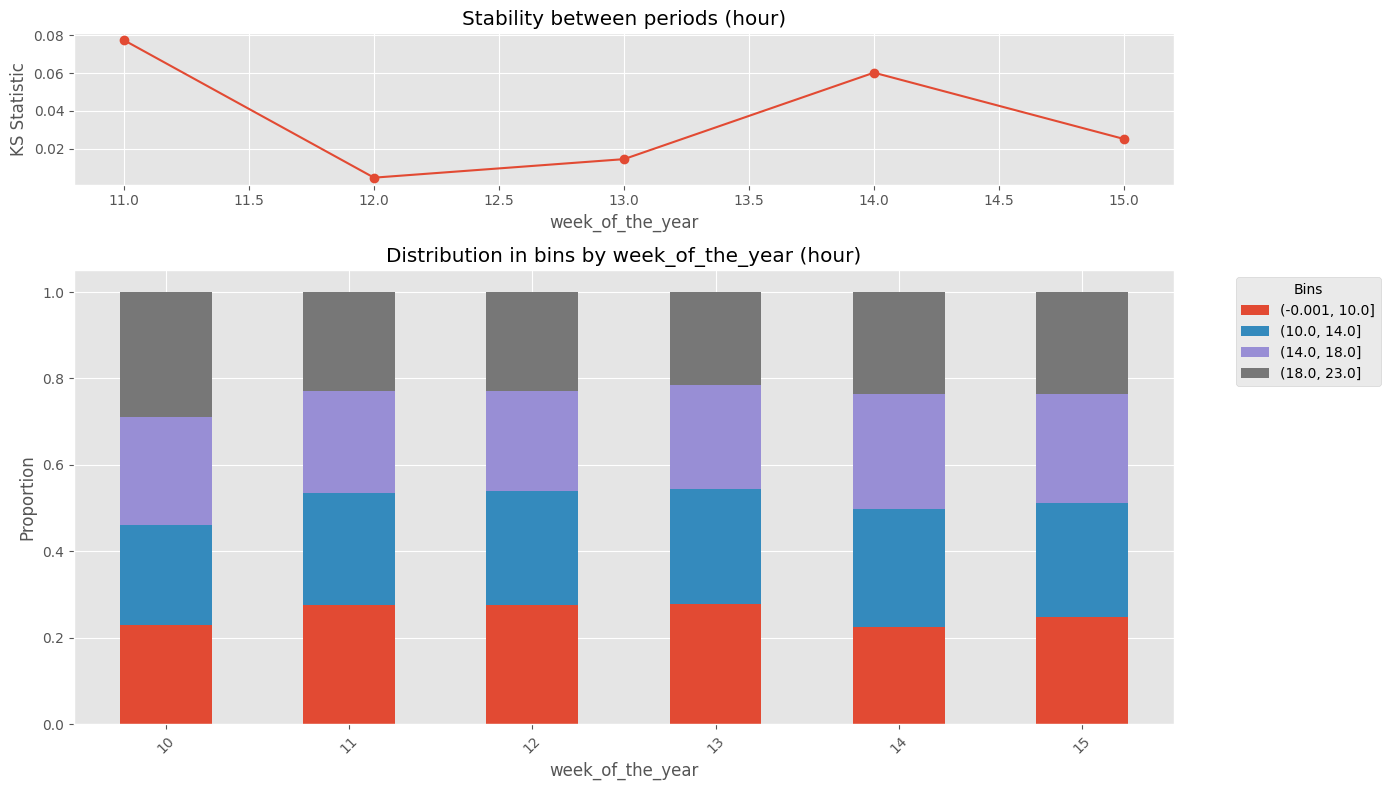

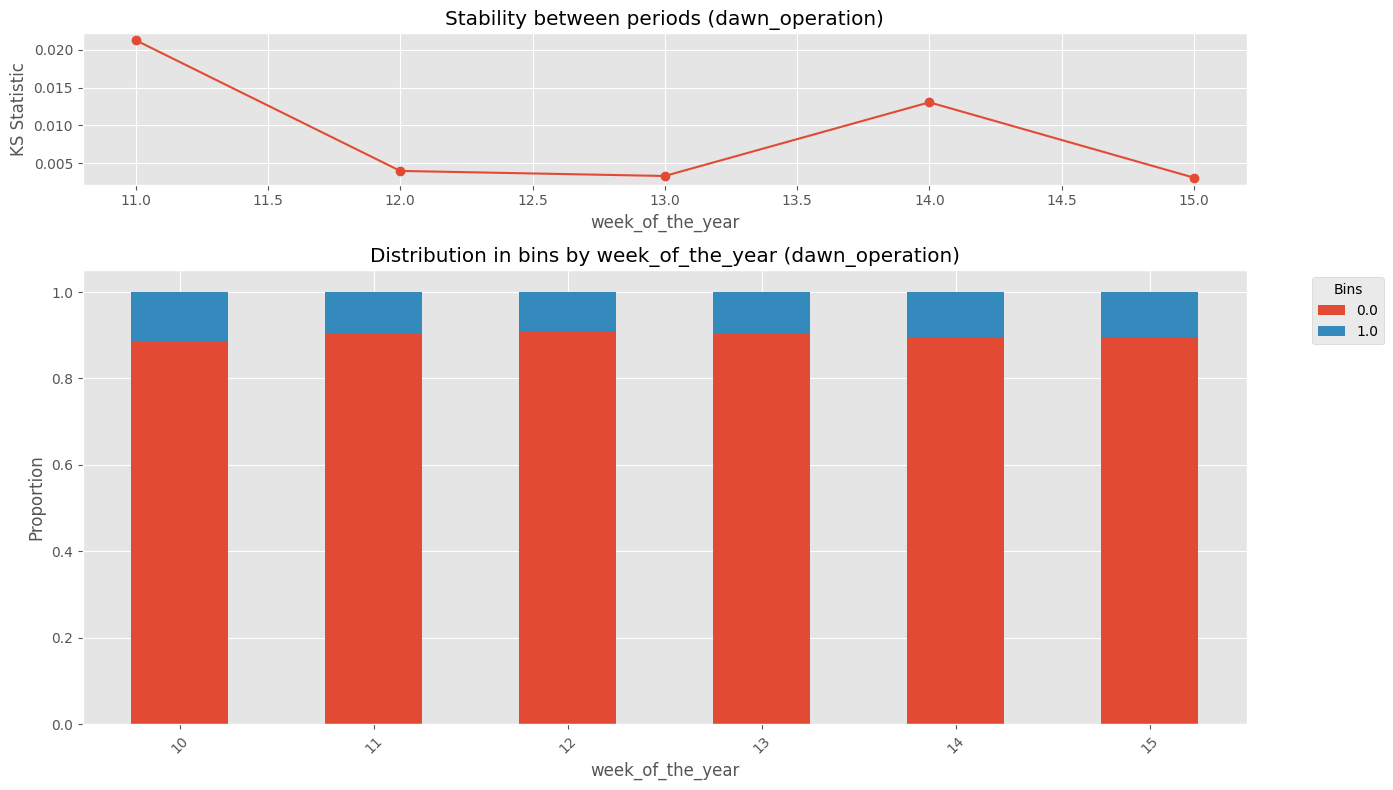

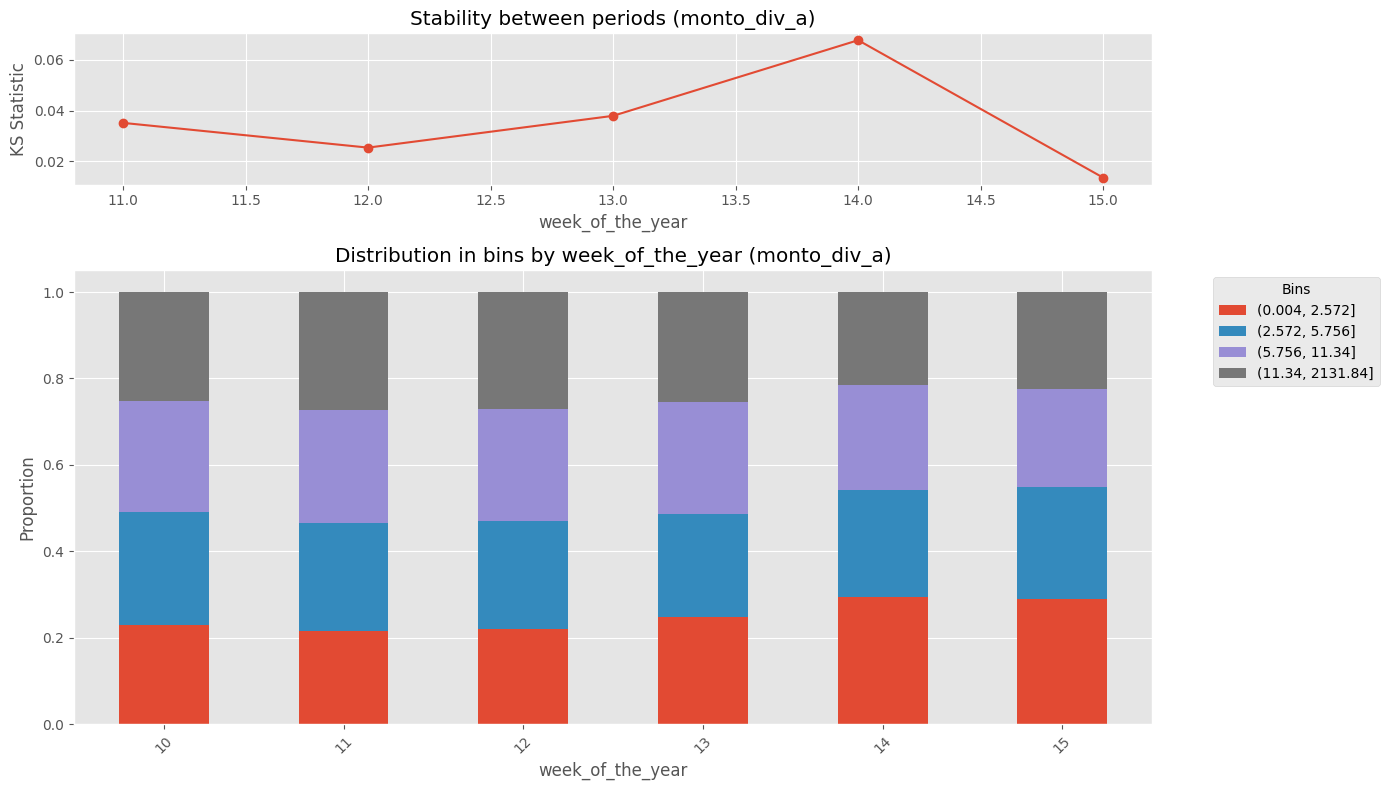

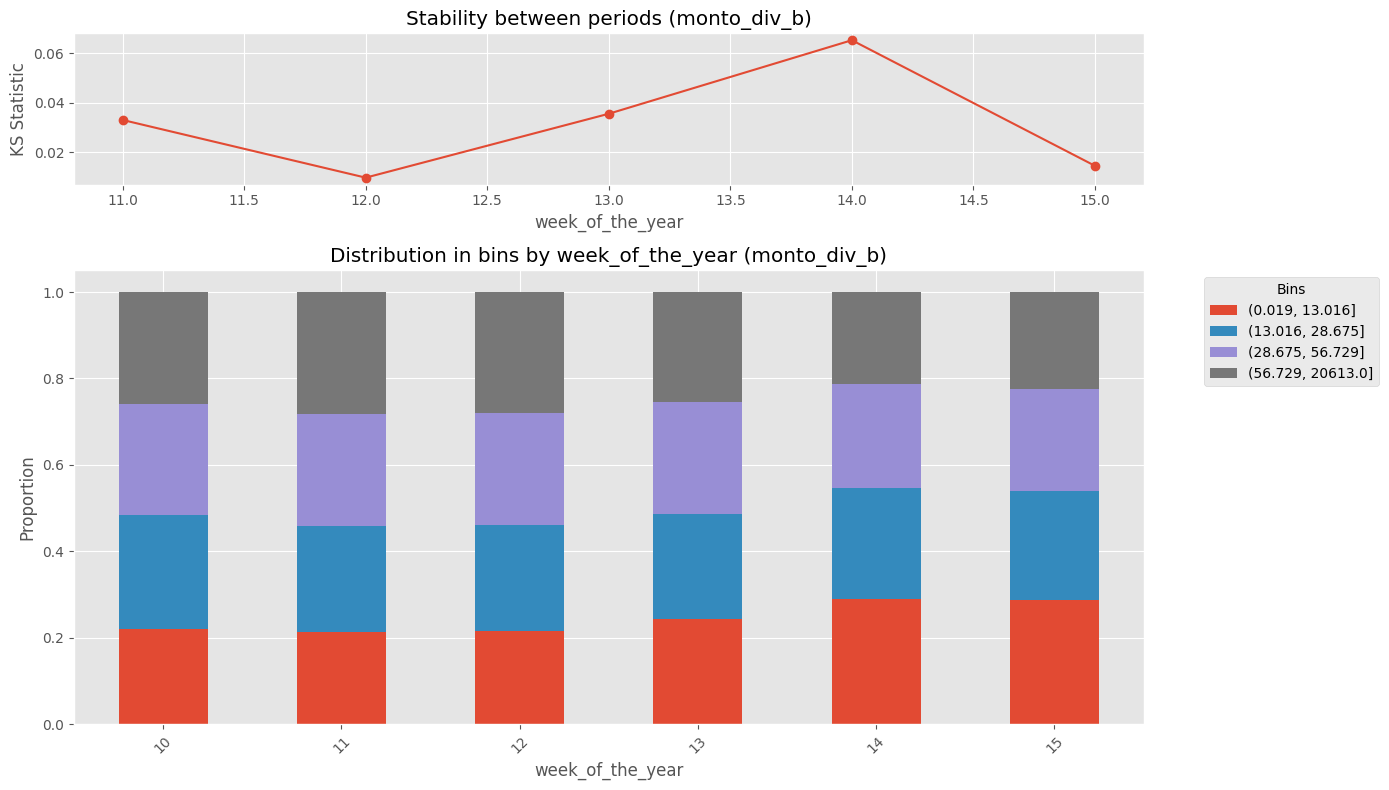

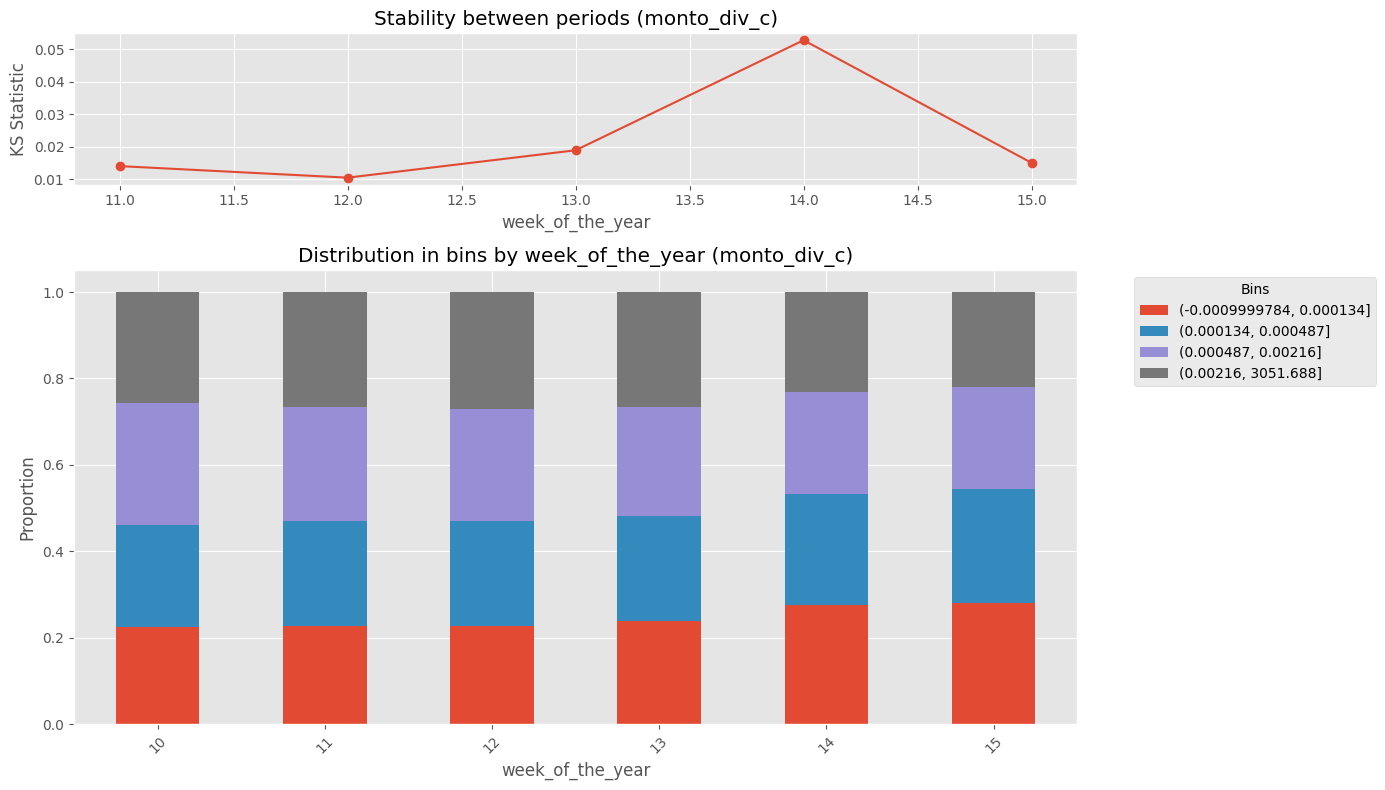

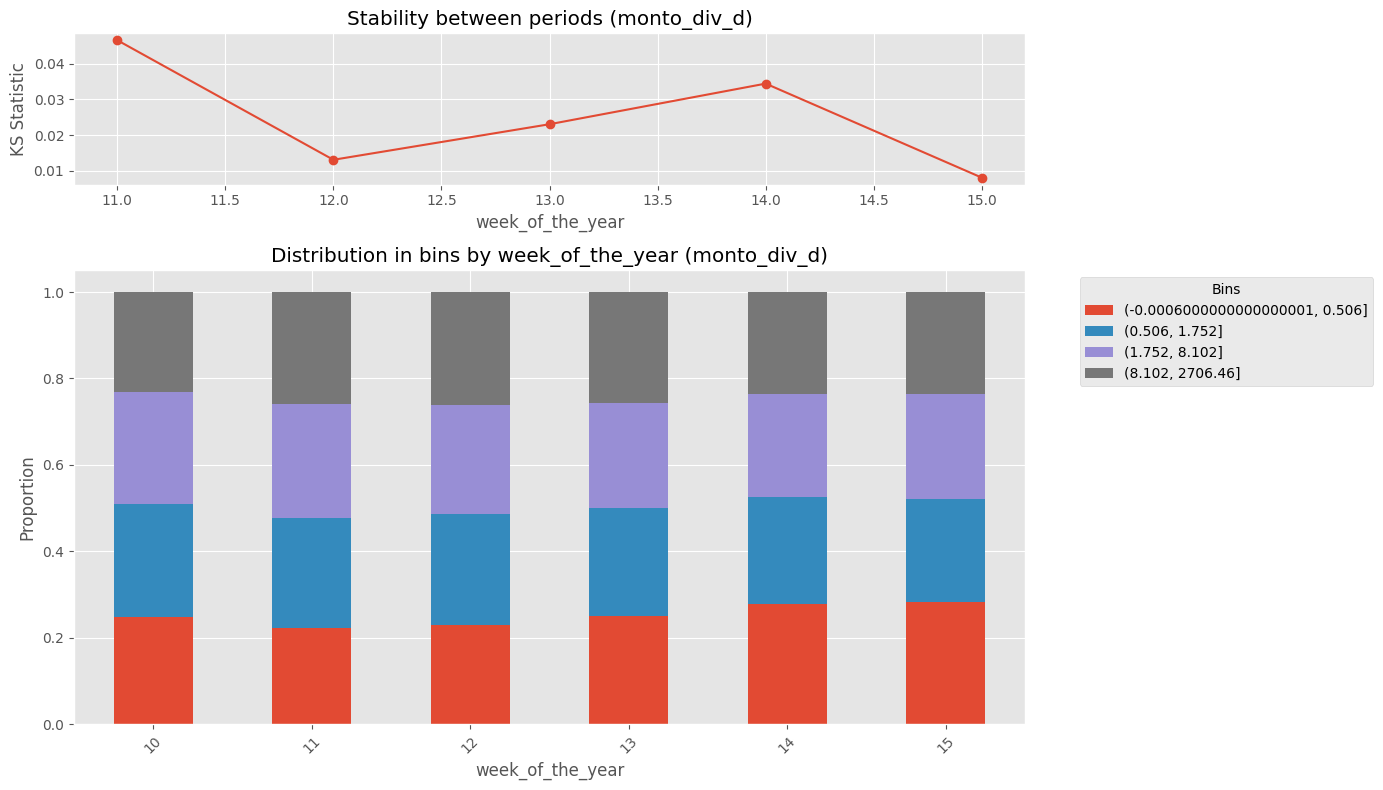

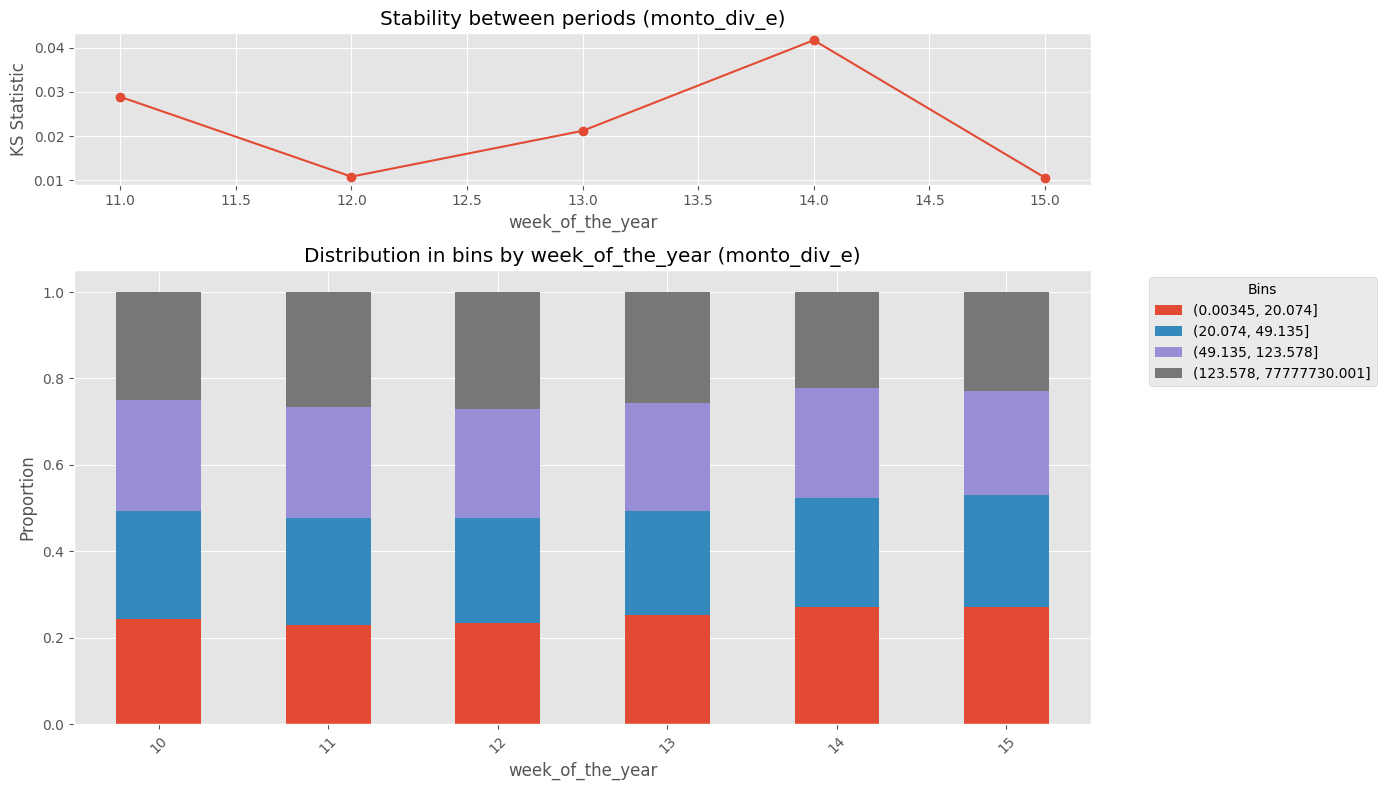

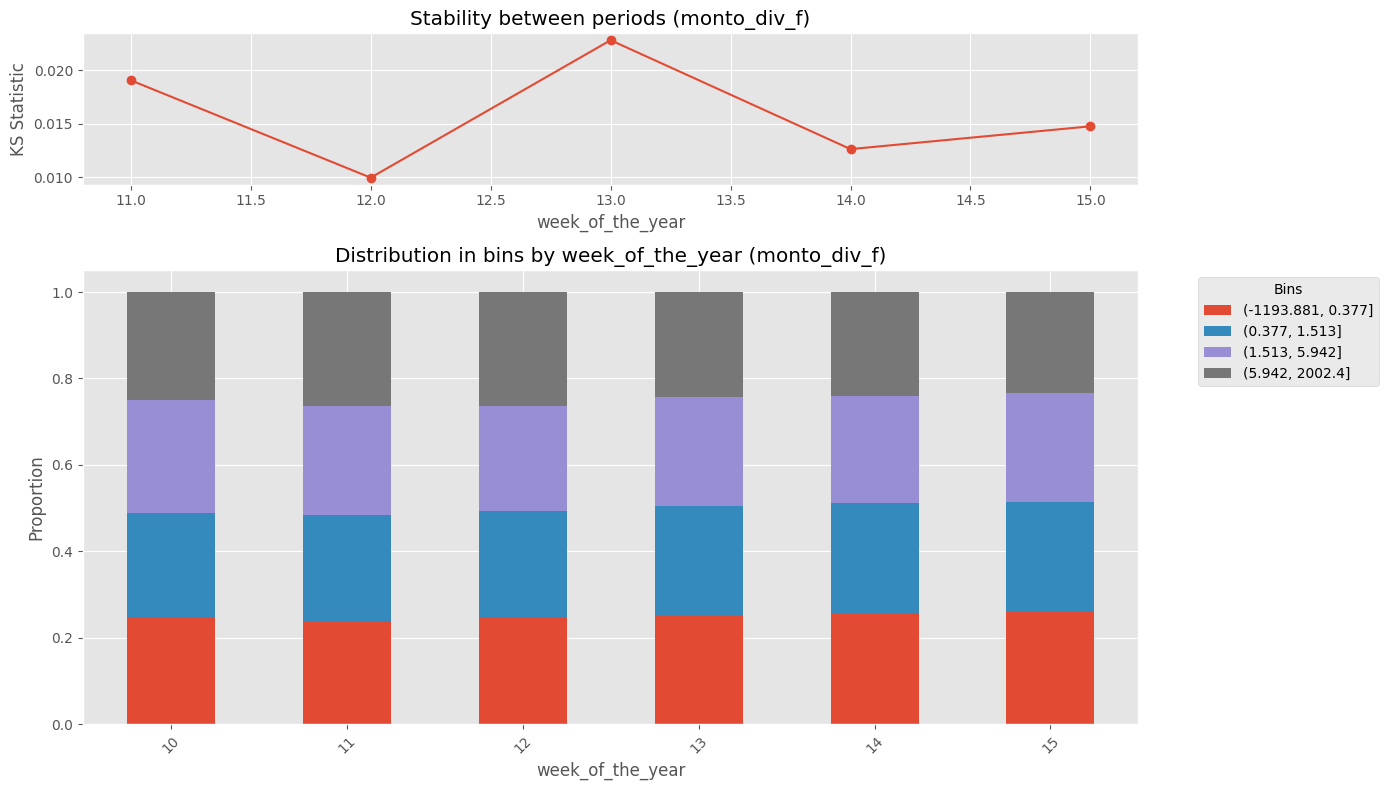

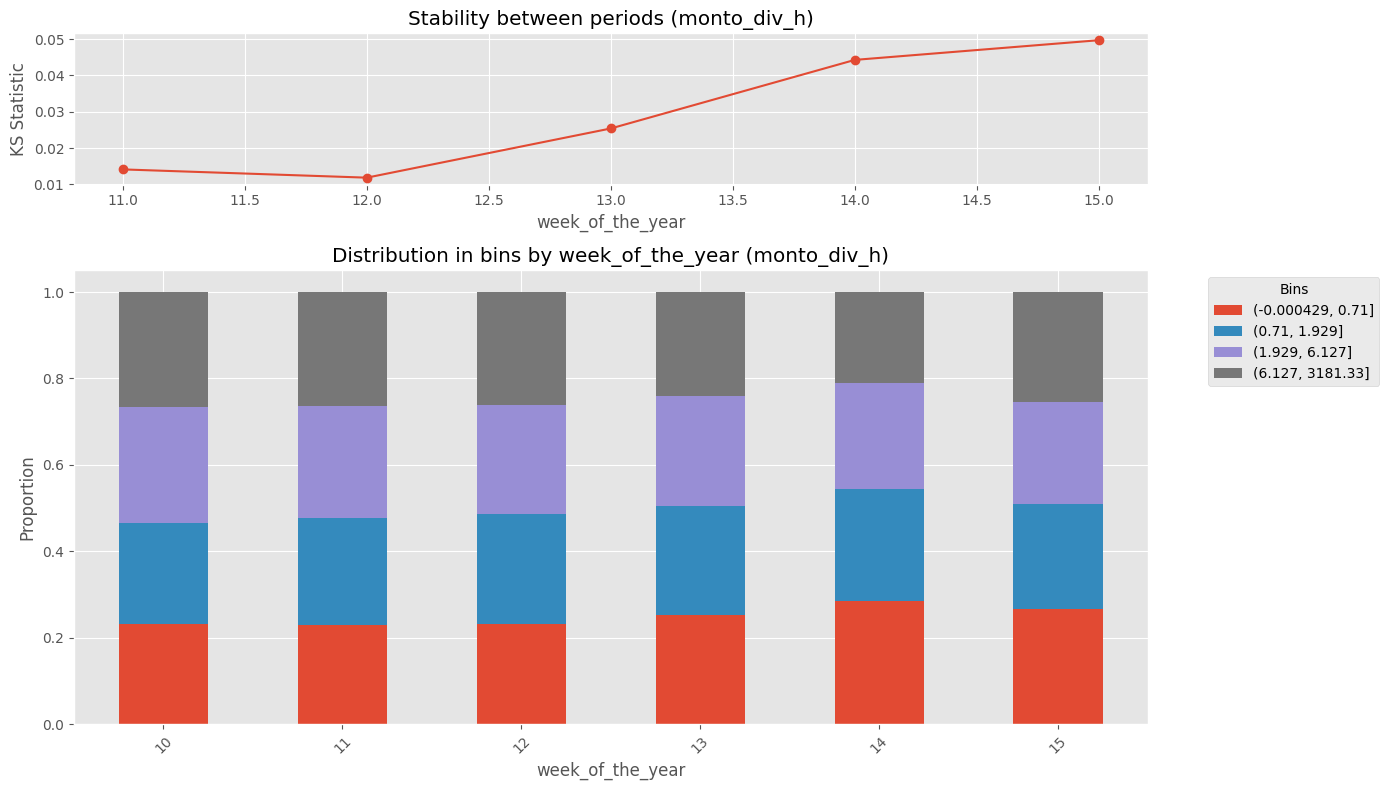

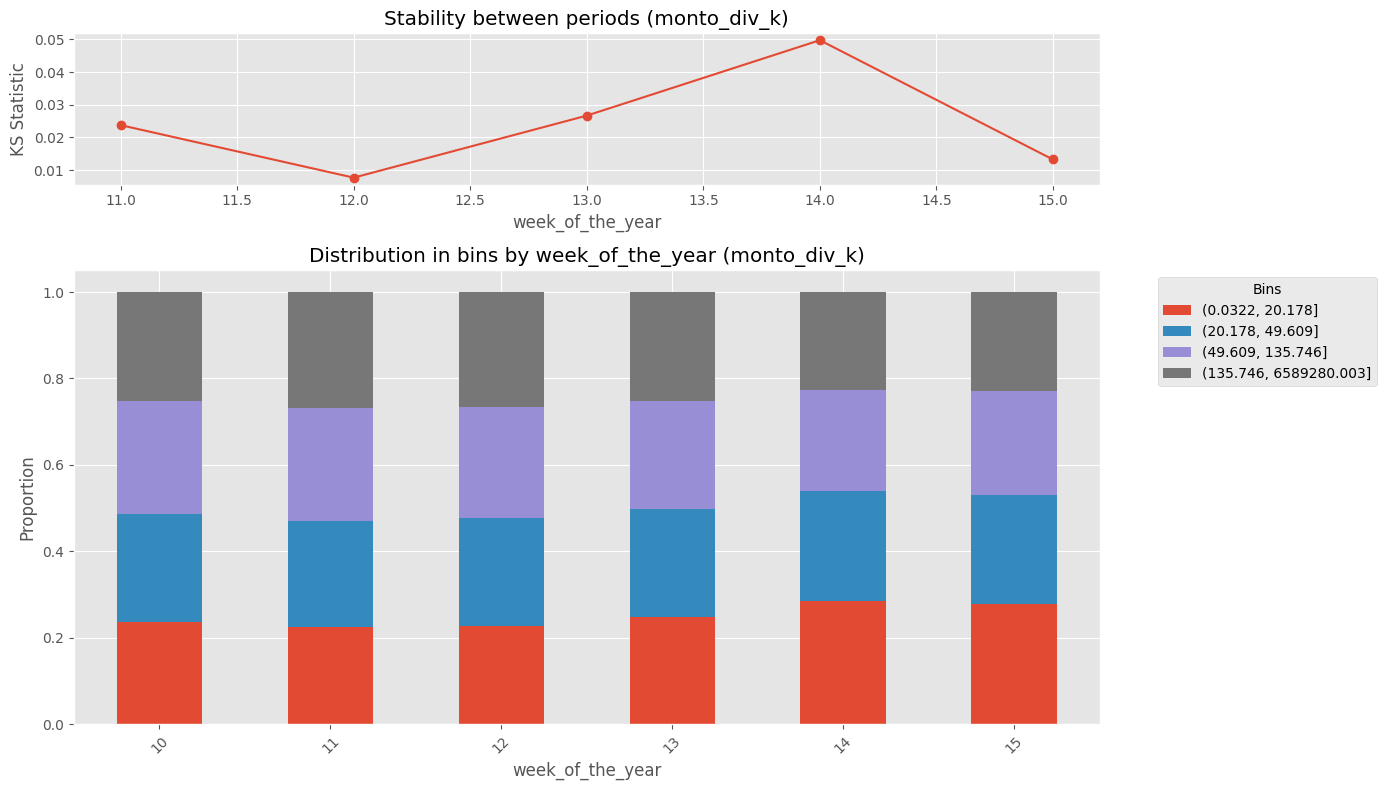

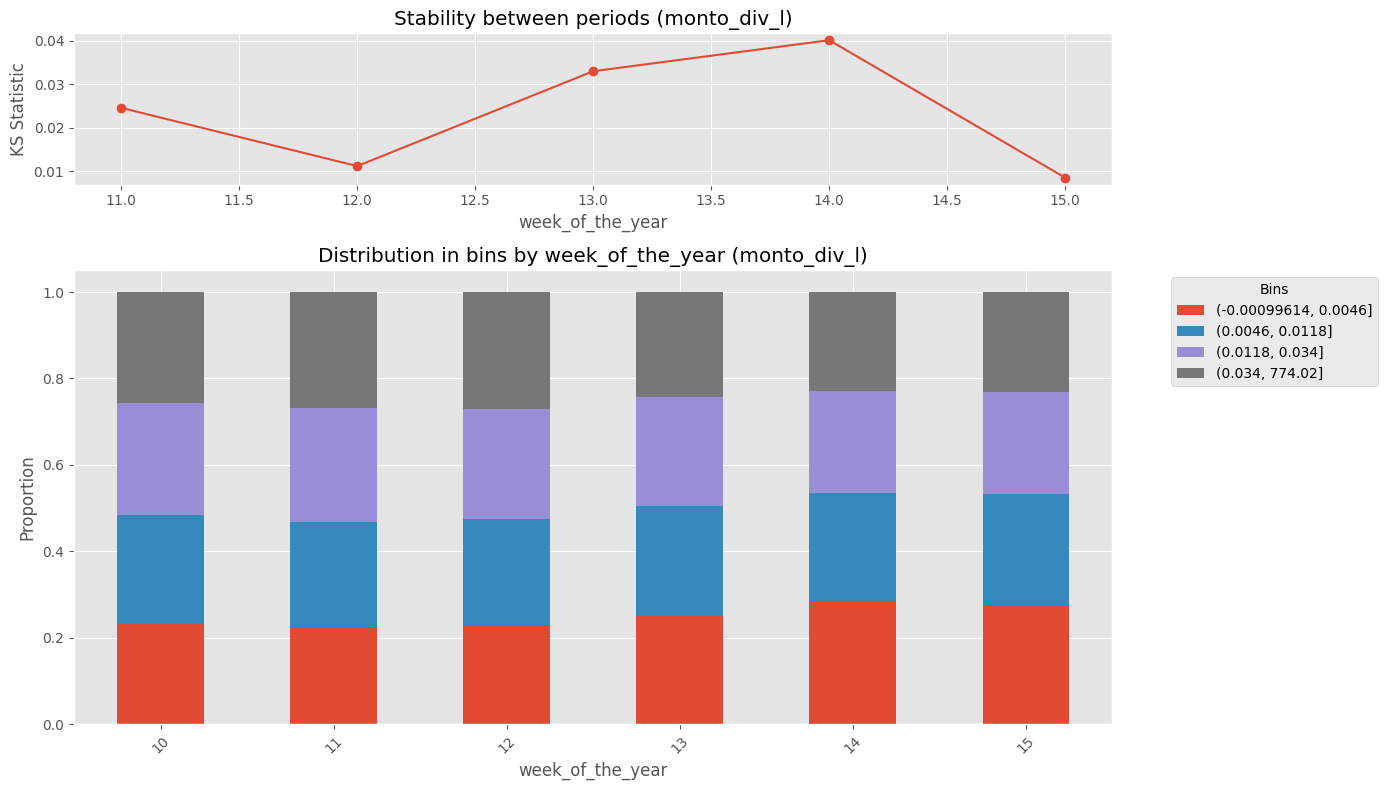

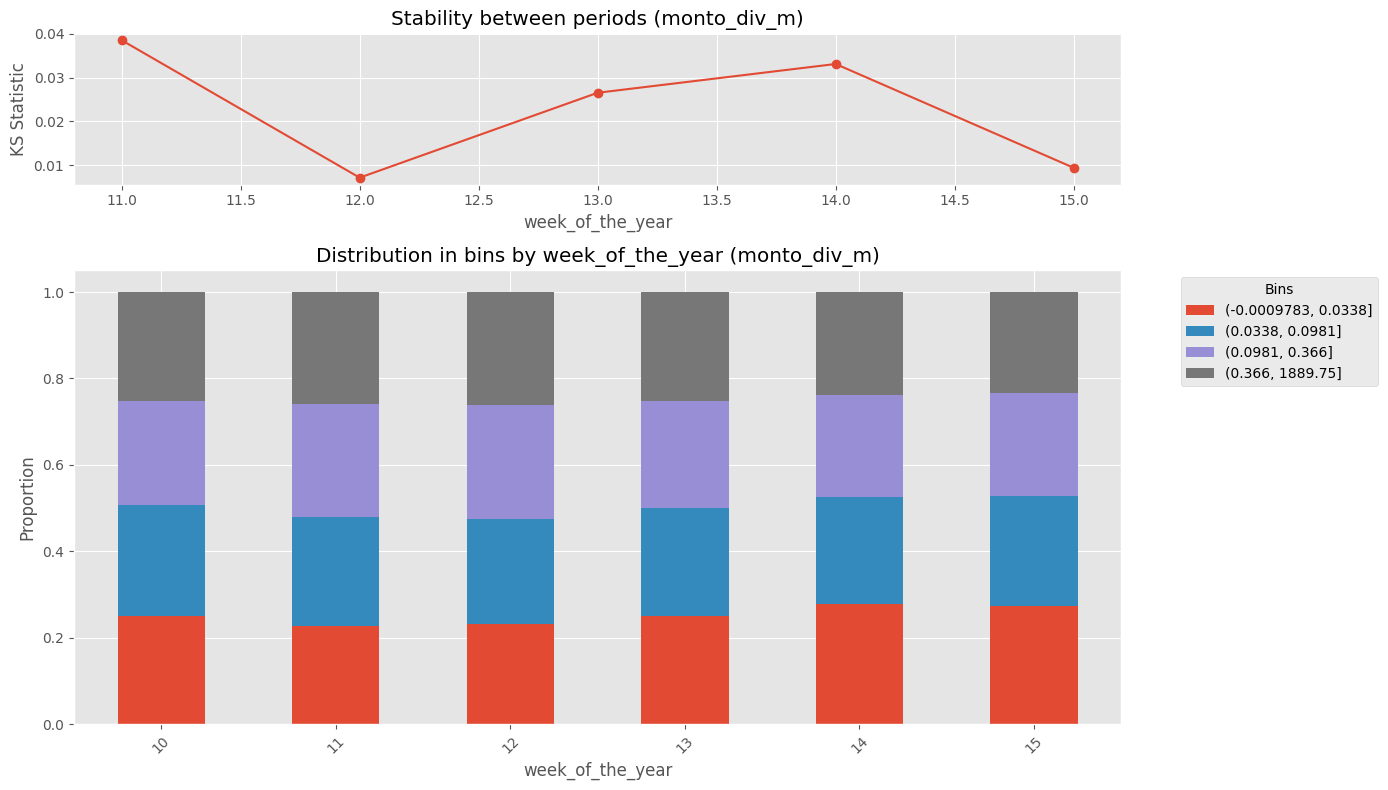

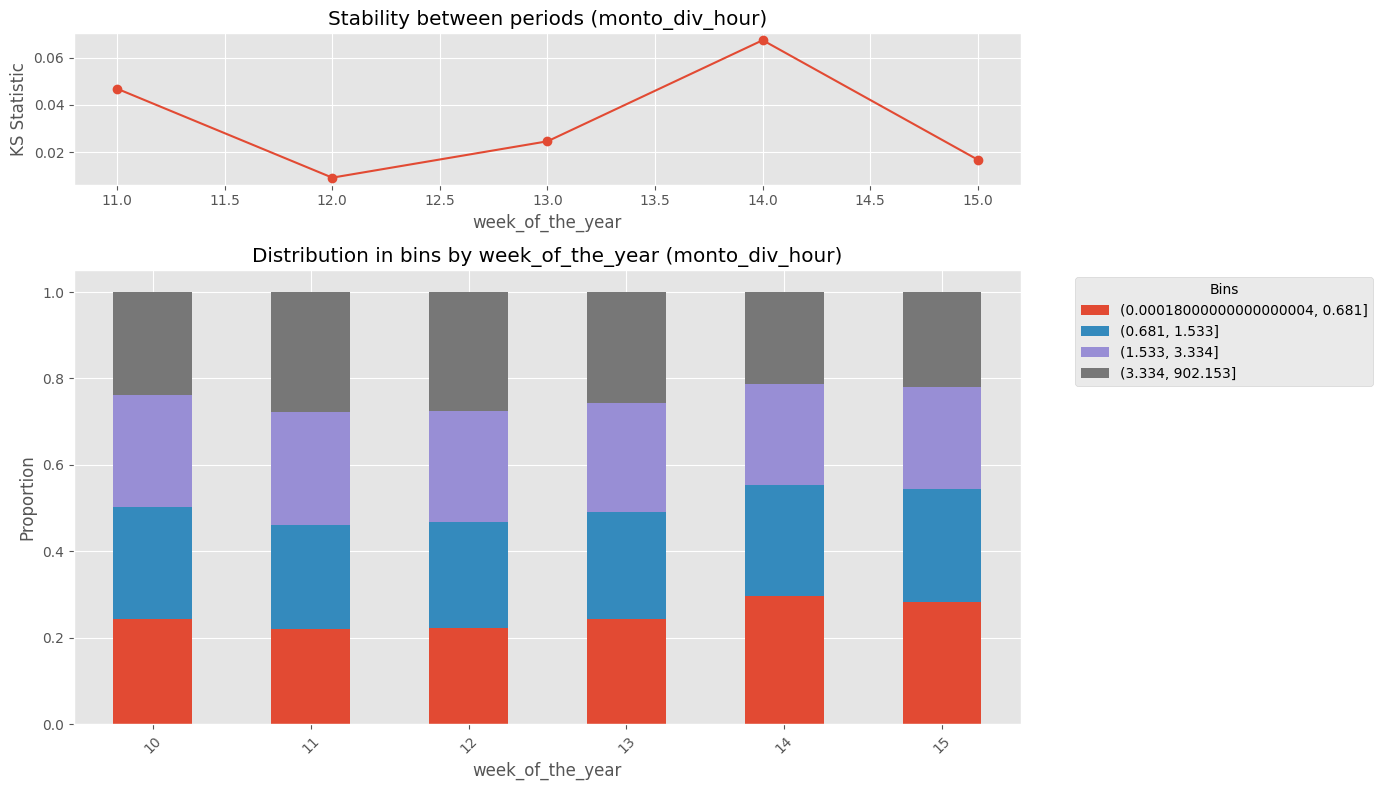

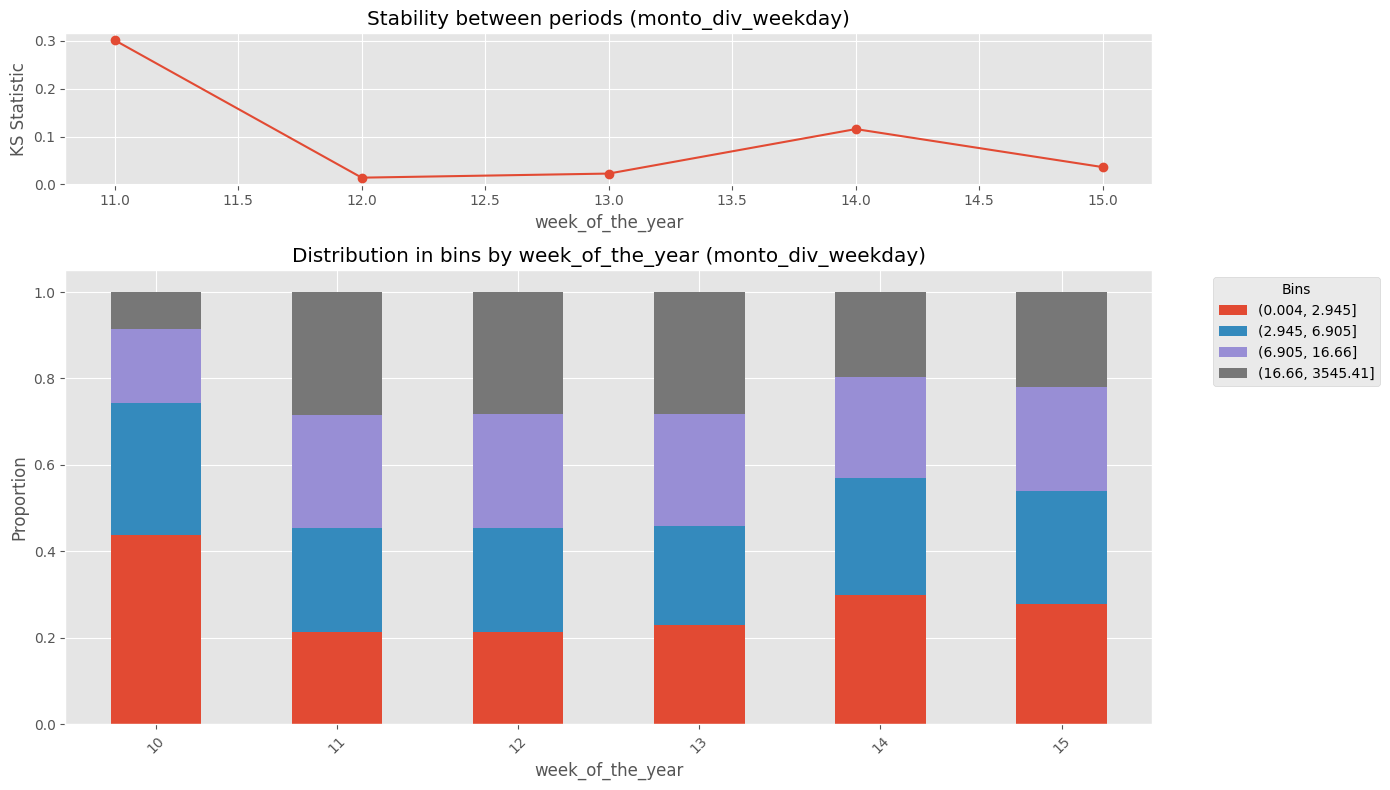

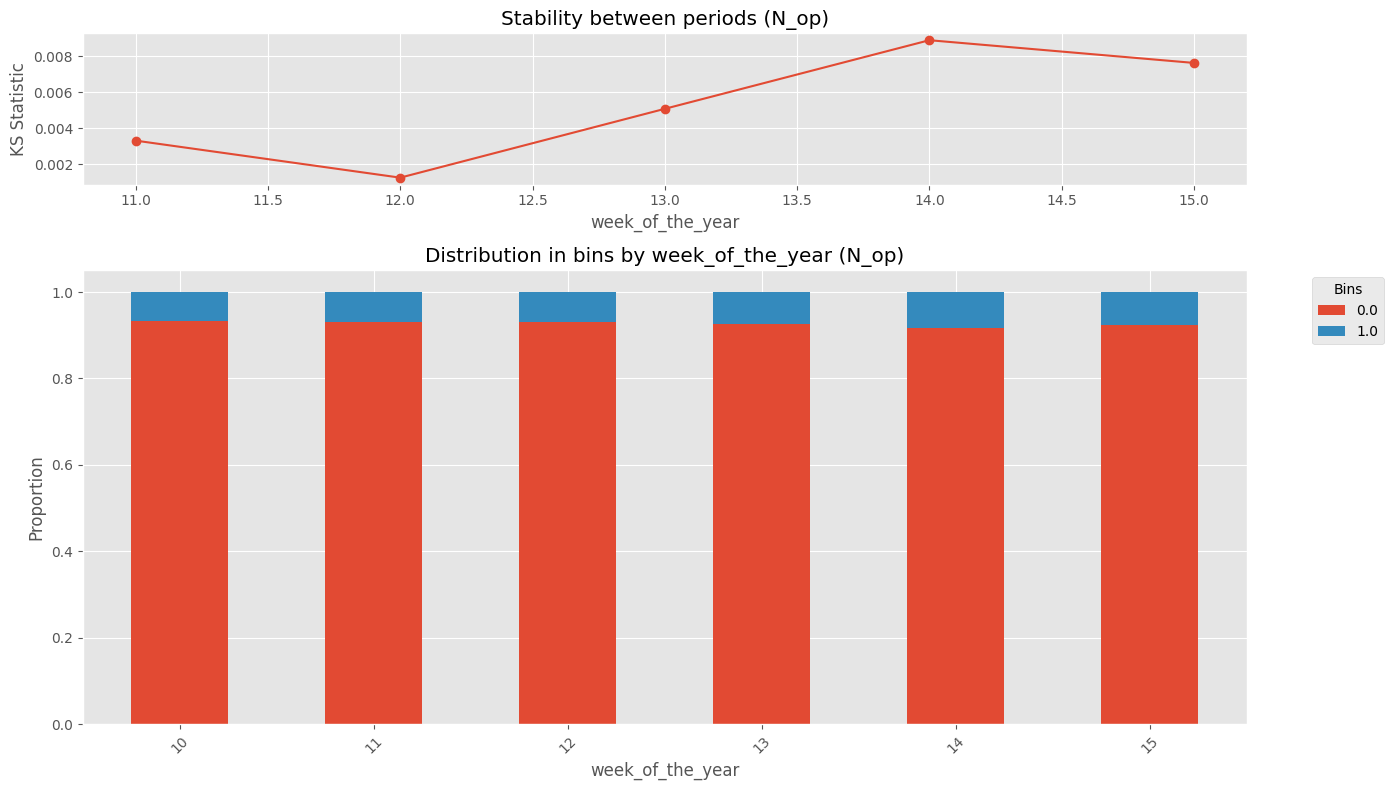

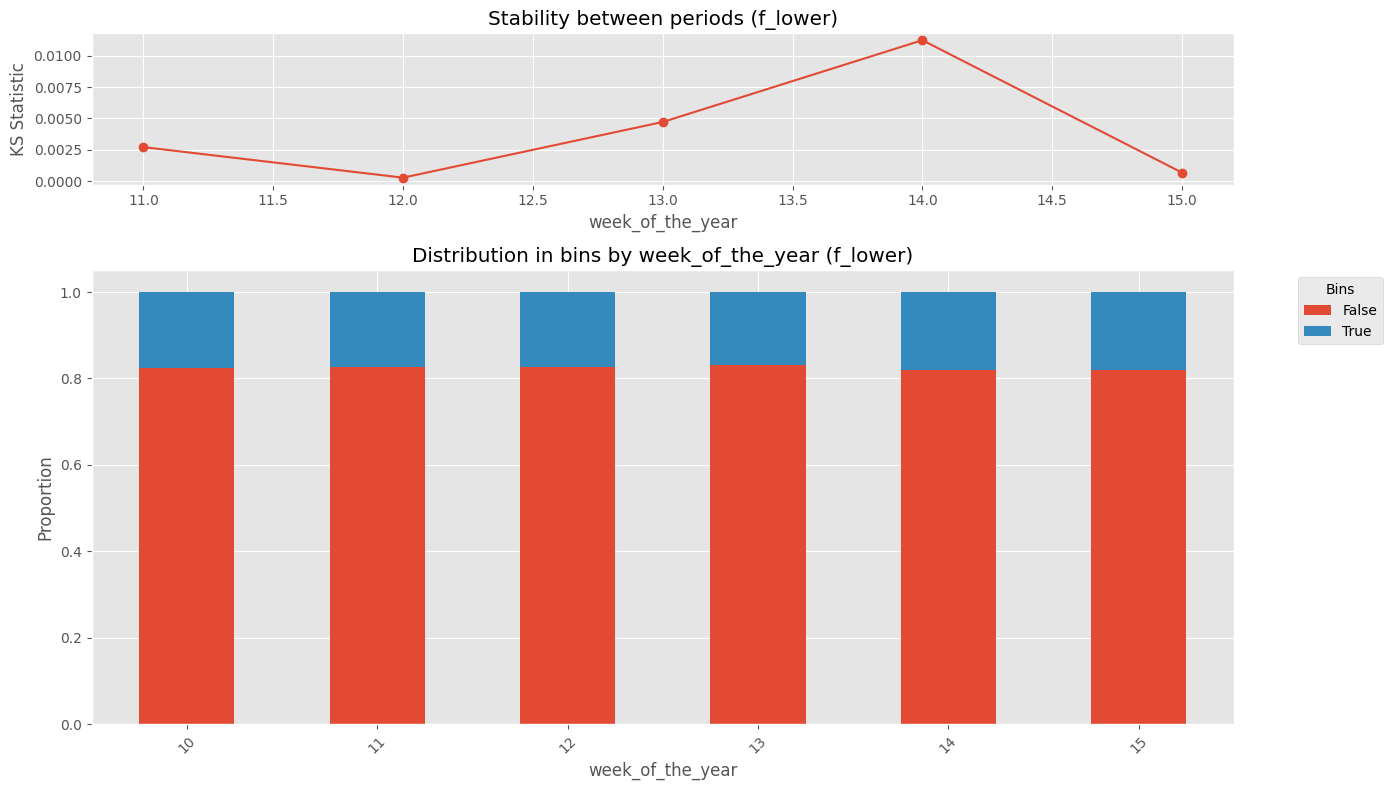

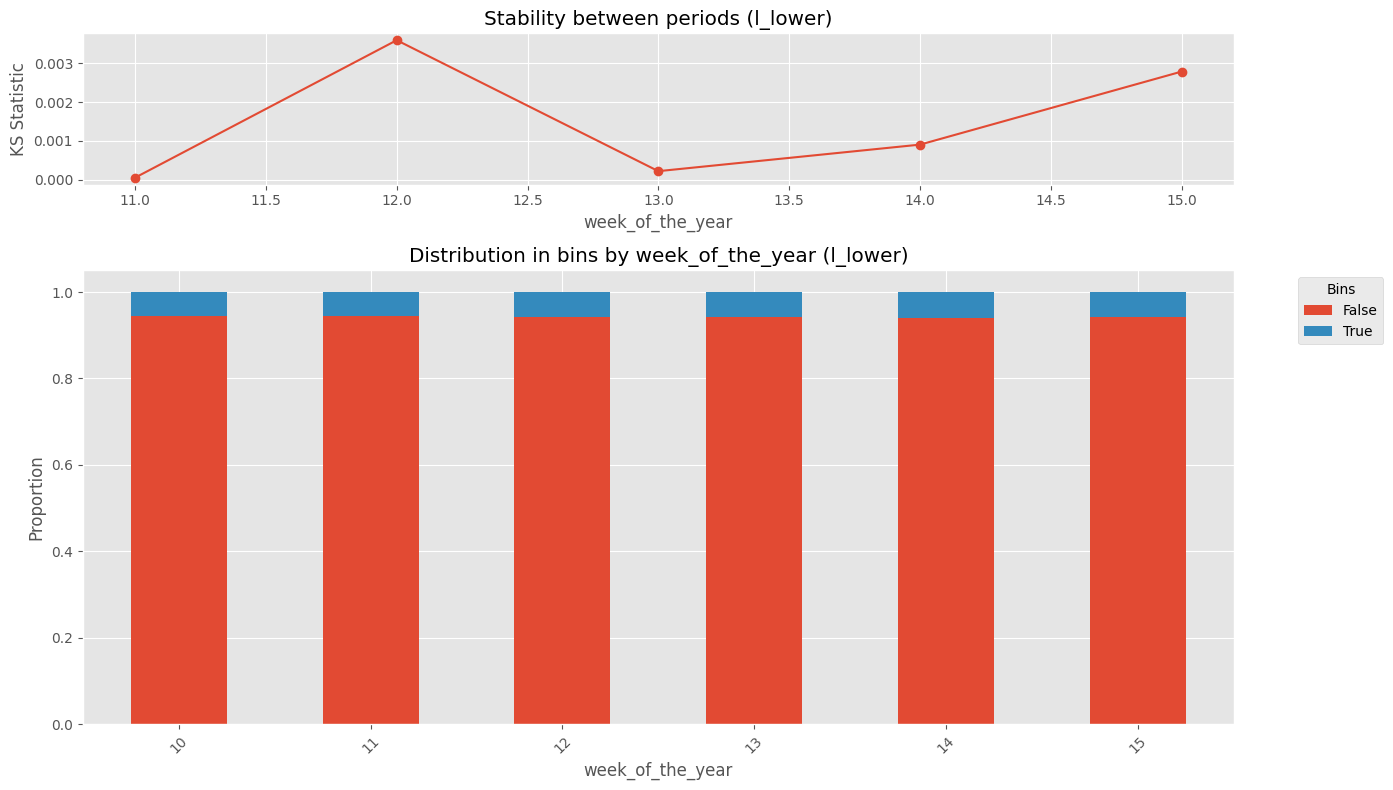

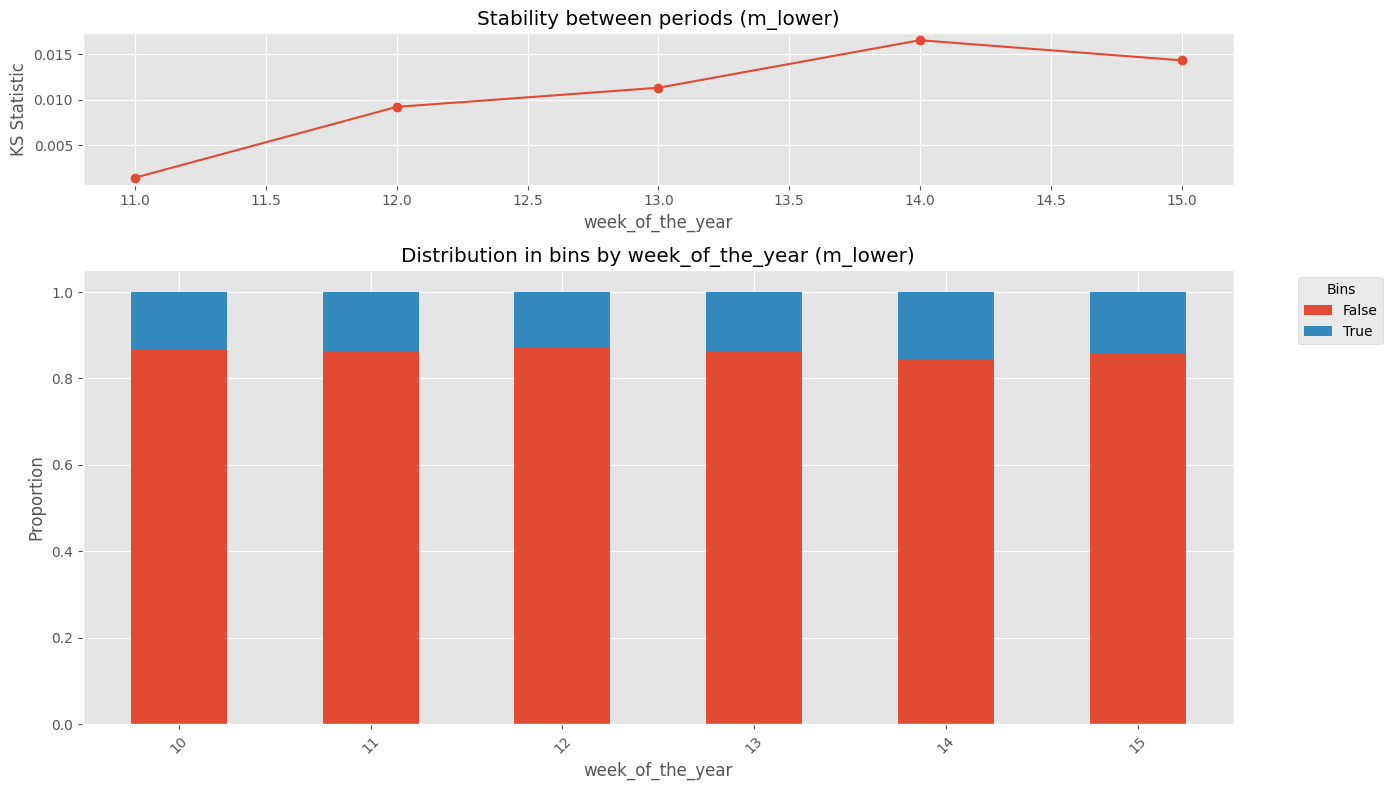

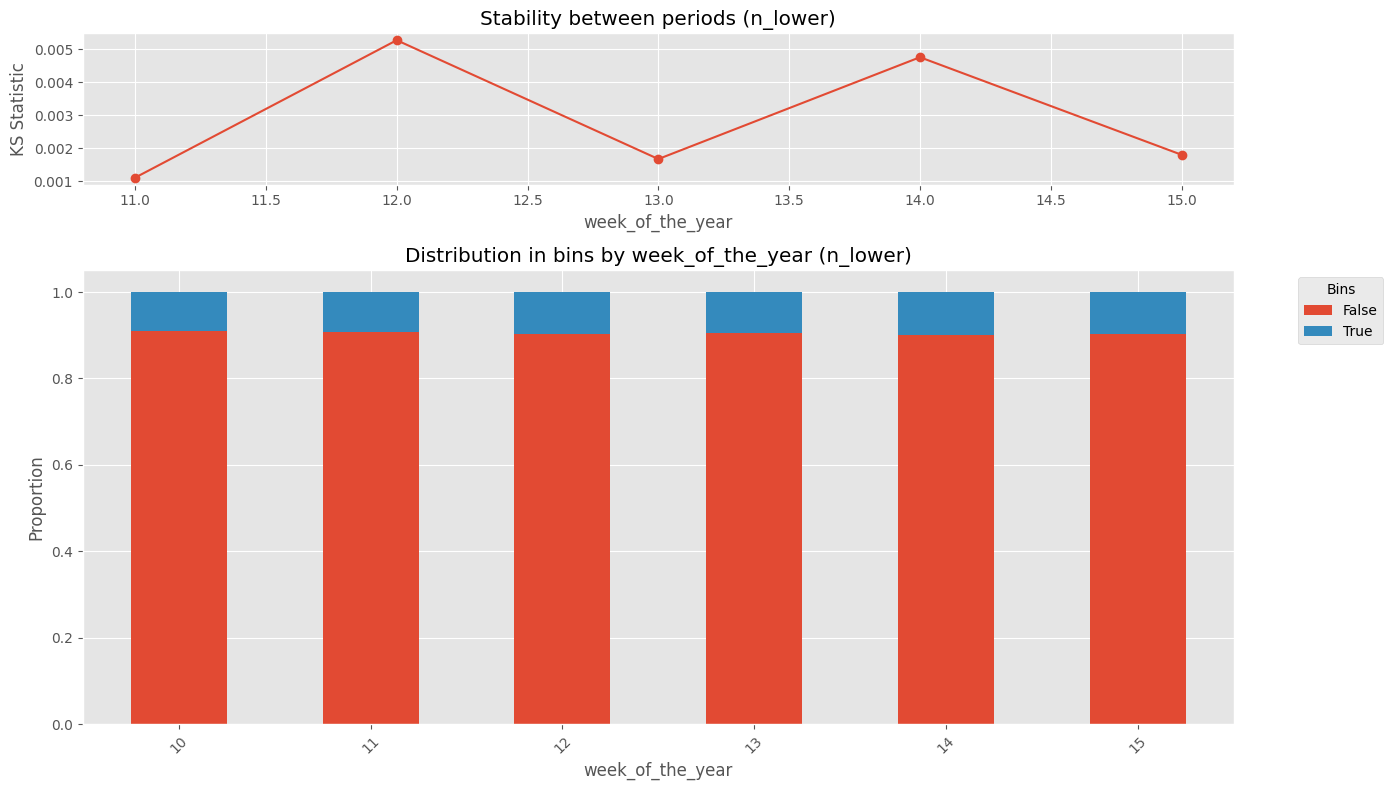

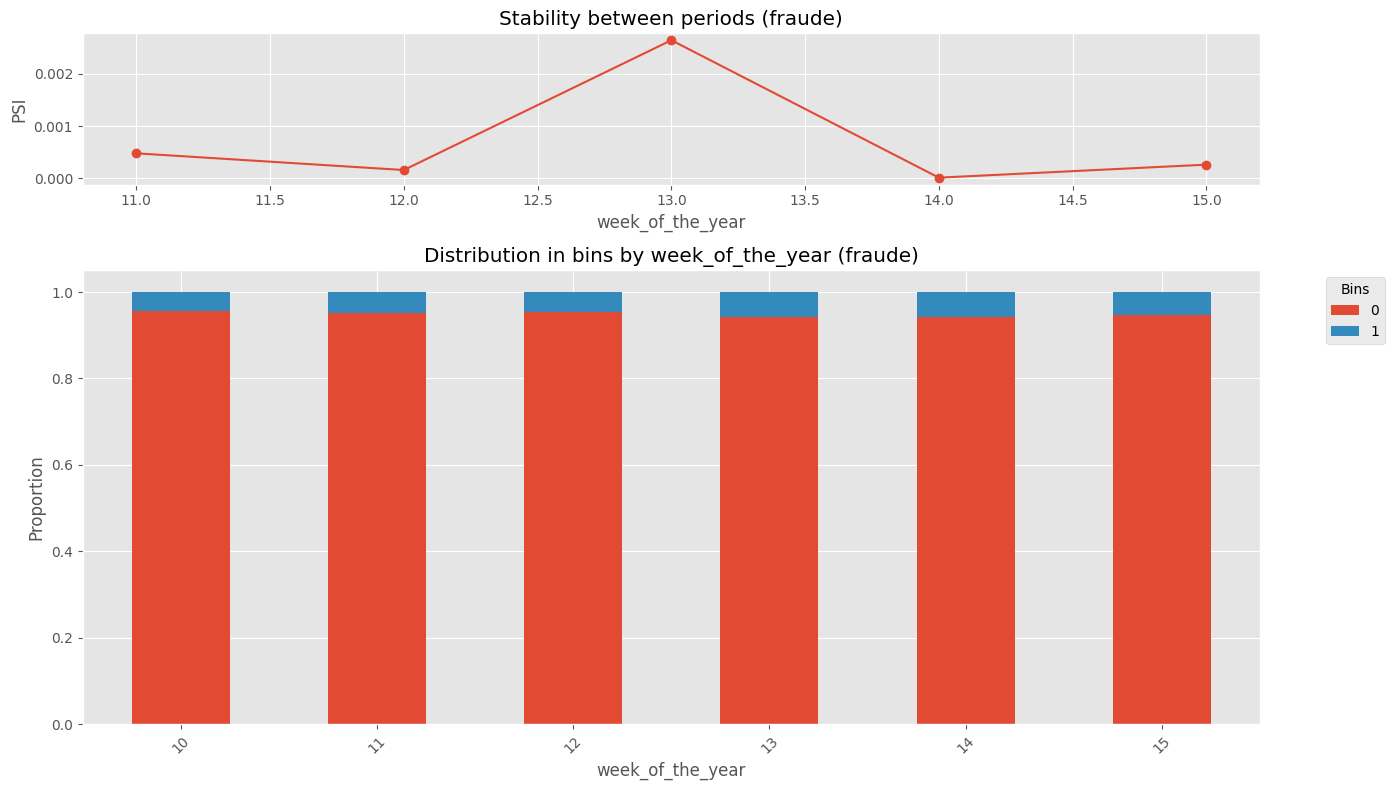

In [5]:
class StabilityReport:
    def __init__(self, df):
        self.df = df.copy()

    def calc_psi(self, expected, actual, epsilon=1e-4):
        """
        Calculate the Population Stability Index (PSI) between two distributions.
        
        Args:
            expected (array): Array with the proportions for each bin in the expected distribution.
            actual (array): Array with the proportions for each bin in the actual distribution.
            epsilon (float): Small value to avoid division by zero. Default is 1e-4.
        
        Returns:
            float: The calculated PSI value.
        """
        psi = 0
        # Ensure no value is zero
        expected = np.where(expected == 0, epsilon, expected)
        actual = np.where(actual == 0, epsilon, actual)
        psi = np.sum((actual - expected) * np.log(actual / expected))
        return psi

    def plot_stability_report(self, col_tempo, features_config_path, variables):
        """
        For the variables selected by Boruta and the time column `col_tempo`, plot:
         - Stacked bar chart showing the distribution of bins over the periods.
         - Line chart showing the evolution of stability (KS for numerical and PSI for categorical).
        
        Args:
            col_tempo (str): Column that defines the periods.
            features_config_path (str): Path to the YAML configuration file.
            variables (list): List of variables to be plotted.
        """
        df = self.df.copy()
        features_config = yaml.safe_load(open(features_config_path, 'r'))
        
        for col in variables:
            if col == "fraude":
                method = "categorical"
            else:
                method = features_config[col]['type']
            
            # If numerical variable, create bins with qcut in quartiles.
            if method == "numerical" and len(df[col].unique()) > 4:
                # In case of duplicate values, use duplicates='drop'
                df['bin'] = pd.qcut(df[col], q=[0, 0.25, 0.5, 0.75, 1], duplicates='drop')
            else:
                # For categorical variables, assume the values themselves are the bins.
                df['bin'] = df[col]
            
            # Sort periods (in case col_tempo is not sorted)
            tempos = sorted(df[col_tempo].unique())
            
            # Create pivot table: rows = periods, columns = bins
            pivot_table = df.groupby([col_tempo, 'bin']).size().unstack(fill_value=0)
            # Calculate proportions by period
            pivot_table_pct = pivot_table.div(pivot_table.sum(axis=1), axis=0)
            
            # Calculate stability between periods:
            # For each period from the second onwards, compare the distribution with the previous period.
            stability = {}
            for i, t in enumerate(tempos):
                if i == 0:
                    stability[t] = np.nan  # no previous period to compare
                else:
                    prev = tempos[i - 1]
                    expected = pivot_table_pct.loc[prev].values.astype(float)
                    actual = pivot_table_pct.loc[t].values.astype(float)
                    if method == "numerical":
                        # For numerical variables, use the KS statistic between the "real" values of the bins.
                        sample_prev = df[df[col_tempo] == prev][col].dropna()
                        sample_actual = df[df[col_tempo] == t][col].dropna()
                        ks_stat, _ = ks_2samp(sample_prev, sample_actual)
                        stability[t] = ks_stat
                    else:
                        # For categorical variables, calculate the PSI between distributions
                        psi_val = self.calc_psi(expected, actual)
                        stability[t] = psi_val
            
            # Create figure with 2 subplots: line above and bars below
            fig, axes = plt.subplots(2, 1, figsize=(14, 8), gridspec_kw={'height_ratios': [1, 3]})
            
            # Plot 1: Stability line
            stability_series = pd.Series(stability).dropna()
            stability_series.sort_index(inplace=True)
            axes[0].plot(stability_series.index, stability_series.values, marker='o', linestyle='-')
            axes[0].set_title(f"Stability between periods ({col})")
            axes[0].set_xlabel(col_tempo)
            if method == "numerical":
                axes[0].set_ylabel("KS Statistic")
            else:
                axes[0].set_ylabel("PSI")
            axes[0].grid(True)
            
            # Plot 2: 100% stacked bars
            pivot_table_pct.plot(kind='bar', stacked=True, ax=axes[1])
            axes[1].set_title(f"Distribution in bins by {col_tempo} ({col})")
            axes[1].set_xlabel(col_tempo)
            axes[1].set_ylabel("Proportion")
            axes[1].tick_params(axis='x', rotation=45)
            axes[1].legend(title='Bins', bbox_to_anchor=(1.05, 1), loc='upper left')
            
            plt.tight_layout()
            plt.show()

    def generate_pdf_report(self, col_tempo, features_config_path, variables, output_path):
        """
        Generate a PDF report with all the stability plots for the selected variables.
        
        Args:
            col_tempo (str): Column that defines the periods.
            features_config_path (str): Path to the YAML configuration file.
            variables (list): List of variables to be plotted.
            output_path (str): Path to save the generated PDF report.
        """
        df = self.df.copy()
        features_config = yaml.safe_load(open(features_config_path, 'r'))
        
        with PdfPages(output_path) as pdf:
            for col in variables:
                if col == "fraude":
                    method = "categorical"
                else:
                    method = features_config[col]['type']
                
                # If numerical variable, create bins with qcut in quartiles.
                if method == "numerical" and len(df[col].unique()) > 4:
                    # In case of duplicate values, use duplicates='drop'
                    df['bin'] = pd.qcut(df[col], q=[0, 0.25, 0.5, 0.75, 1], duplicates='drop')
                else:
                    # For categorical variables, assume the values themselves are the bins.
                    df['bin'] = df[col]
                
                # Sort periods (in case col_tempo is not sorted)
                tempos = sorted(df[col_tempo].unique())
                
                # Create pivot table: rows = periods, columns = bins
                pivot_table = df.groupby([col_tempo, 'bin']).size().unstack(fill_value=0)
                # Calculate proportions by period
                pivot_table_pct = pivot_table.div(pivot_table.sum(axis=1), axis=0)
                
                # Calculate stability between periods:
                # For each period from the second onwards, compare the distribution with the previous period.
                stability = {}
                for i, t in enumerate(tempos):
                    if i == 0:
                        stability[t] = np.nan  # no previous period to compare
                    else:
                        prev = tempos[i - 1]
                        expected = pivot_table_pct.loc[prev].values.astype(float)
                        actual = pivot_table_pct.loc[t].values.astype(float)
                        if method == "numerical":
                            # For numerical variables, use the KS statistic between the "real" values of the bins.
                            sample_prev = df[df[col_tempo] == prev][col].dropna()
                            sample_actual = df[df[col_tempo] == t][col].dropna()
                            ks_stat, _ = ks_2samp(sample_prev, sample_actual)
                            stability[t] = ks_stat
                        else:
                            # For categorical variables, calculate the PSI between distributions
                            psi_val = self.calc_psi(expected, actual)
                            stability[t] = psi_val
                
                # Create figure with 2 subplots: line above and bars below
                fig, axes = plt.subplots(2, 1, figsize=(14, 8), gridspec_kw={'height_ratios': [1, 3]})
                
                # Plot 1: Stability line
                stability_series = pd.Series(stability).dropna()
                stability_series.sort_index(inplace=True)
                axes[0].plot(stability_series.index, stability_series.values, marker='o', linestyle='-')
                axes[0].set_title(f"Stability between periods ({col})")
                axes[0].set_xlabel(col_tempo)
                if method == "numerical":
                    axes[0].set_ylabel("KS Statistic")
                else:
                    axes[0].set_ylabel("PSI")
                axes[0].grid(True)
                
                # Plot 2: 100% stacked bars
                pivot_table_pct.plot(kind='bar', stacked=True, ax=axes[1])
                axes[1].set_title(f"Distribution in bins by {col_tempo} ({col})")
                axes[1].set_xlabel(col_tempo)
                axes[1].set_ylabel("Proportion")
                axes[1].tick_params(axis='x', rotation=45)
                axes[1].legend(title='Bins', bbox_to_anchor=(1.05, 1), loc='upper left')
                
                plt.tight_layout()
                pdf.savefig(fig)
                plt.close(fig)

report = StabilityReport(df)
report.plot_stability_report(col_tempo="week_of_the_year", features_config_path=features_config_path, variables=features_selected + ["fraude"])


# Resultado

Ótimo! Todas variáveis selecionadas, tanto numéricas, quanto categóricas e binárias, apresentaram boa estabilidade durante as safras de treinamento.

Podemos seguir para treinar o modelo!